In [1]:
# ==========================================
# ⚡ GPU + XLA acceleration (added at top)
# ==========================================
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=2"   # Enable XLA fusion
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"             # suppress TF INFO/WARN
os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"            # suppress verbose C++ logs

import logging, absl.logging
import tensorflow as tf

# 🔧 Threading config MUST be set before TF runtime initializes
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

# Logging levels
tf.get_logger().setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)

# XLA JIT
tf.config.optimizer.set_jit(True)                    # Just-In-Time compile

# Enable full GPU memory and multi-GPU graph
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ {len(gpus)} GPU(s) active, memory growth enabled.")
else:
    print("ℹ️ CPU mode.")

tf.debugging.set_log_device_placement(False)



# =========================
# Cell 1 — Setup & Splits
# =========================
import os

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 2=warnings+errors, 3=errors only
os.environ["TF_NUM_INTEROP_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"

import json, random
import numpy as np
import h5py
import joblib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import logging
import absl.logging
tf.get_logger().setLevel('ERROR')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
absl.logging.set_verbosity(absl.logging.ERROR)



# --- Quiet TF a bit ---
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# # --- GPU: enable memory growth if present (safe no-op on CPU) ---
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     try:
#         for g in gpus:
#             tf.config.experimental.set_memory_growth(g, True)
#         print(f"✅ GPUs: {len(gpus)} | Memory growth enabled")
#     except Exception as e:
#         print("⚠️ GPU setup issue:", e)
# else:
#     print("ℹ️ No GPU detected (CPU mode)")

# --- Paths ---
DATA_DIR = os.getenv("PBROM_DATA_DIR", "PBROM data")  # change if your folder name differs
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("scalers", exist_ok=True)
os.makedirs("ablation", exist_ok=True)
os.makedirs("figs", exist_ok=True)

# # --- ⭐️ MODIFIED: File lists are now grouped ⭐️ ---
# This is now the "single source of truth" for all files.
# Based on your request for granular, per-cell groups.


TRAIN_GROUPS = {
    "NASA_Cells_1": [
        "PBROM_data_NASA_B7.mat",
    ]
}

VAL_GROUPS = {
    "NASA_Cells_1_Val": [
        "PBROM_data_NASA_B6.mat",
    ]
}

TEST_GROUPS = {
    "NASA_Cells_1_Test": [
        "PBROM_data_NASA_B5.mat",
    ]
}



# --- ⭐️ NEW: Auto-generate flat lists and lookup map ⭐️ ---
# (This code builds all the helper lists we need)

TRAIN_FILES = [f for files in TRAIN_GROUPS.values() for f in files]
VAL_FILES = [f for files in VAL_GROUPS.values() for f in files]
TEST_FILES = [f for files in TEST_GROUPS.values() for f in files]

# This is our critical "lookup map"
# It maps every single file to a group name, which we use to load the correct scaler
FILE_TO_GROUP_MAP = {}
all_groups = {**TRAIN_GROUPS, **VAL_GROUPS, **TEST_GROUPS}
for group, files in all_groups.items():
    for f in files:
        # We find the "base" name for the scaler (e.g., "PBROM_Cells_1")
        # This allows "PBROM_Cells_1_Val" to use the "PBROM_Cells_1" scaler
        base_group = group.split('_Val')[0].split('_Test')[0]
        FILE_TO_GROUP_MAP[f] = base_group

print(f"✅ File map generated: {len(FILE_TO_GROUP_MAP)} files mapped to base groups.")
print(f"  Example lookup: {TRAIN_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TRAIN_FILES[0])}")
print(f"  Example lookup: {VAL_FILES[0]} -> {FILE_TO_GROUP_MAP.get(VAL_FILES[0])}")
print(f"  Example lookup: {TEST_FILES[0]} -> {FILE_TO_GROUP_MAP.get(TEST_FILES[0])}")
# -----------------------------------------------------------


# --- Helper: robust HDF5 .mat loader (squeezes to 1D/2D np arrays) ---
def _read_field(f, key, required=True):
    if key not in f:
        if required:
            raise KeyError(f"Missing key '{key}' in MAT file.")
        return None
    arr = np.array(f[key])
    # MATLAB often stores column vectors as (1, N) or (N, 1); squeeze safely
    return np.squeeze(arr)

def load_mat(file_name):
    """
    Loads a PBROM/NASA cell .mat file and returns a dict of numpy arrays:
      I_p, SOC_p, Time_s_p, Q_exp_p, Q_total_p, V_cum_p, Temp_cum_p,
      C_rate_profile, Bat_cap_profile, R_ch_profile, V_max_profile, V_min_profile,
      Cap_Nom, t_exp
    """
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Couldn't find: {path}")
    with h5py.File(path, "r") as f:
        data = {
            "I_p":                 _read_field(f, "I_p"),
            "SOC_p":               _read_field(f, "SOC_p"),
            "Time_s_p":            _read_field(f, "Time_s_p"),
            "Q_exp_p":             _read_field(f, "Q_exp_p"),
            "Q_total_p":           _read_field(f, "Q_total_p"),
            "V_cum_p":             _read_field(f, "V_cum_p"),
            "Temp_cum_p":          _read_field(f, "Temp_cum_p"),
            "C_rate_profile":      _read_field(f, "C_rate_profile"),
            "Bat_cap_profile":     _read_field(f, "Bat_cap_profile"),
            "R_ch_profile":        _read_field(f, "R_ch_profile"),
            "V_max_profile":       _read_field(f, "V_max_profile"),
            "V_min_profile":       _read_field(f, "V_min_profile"),
            "Cap_Nom":             _read_field(f, "Cap_Nom"),
            "t_exp":               _read_field(f, "t_exp"),
        }
    return data

# --- Quick sanity: print counts and peek sizes if files exist ---
def _peek(files, tag):
    ok = 0
    for fn in files:
        try:
            d = load_mat(fn)
            n = len(np.atleast_1d(d["Time_s_p"]))
            print(f"[{tag}] {fn}: N={n}")
            ok += 1
        except Exception as e:
            print(f"[{tag}] {fn}: ({e})")
    print(f"[{tag}] Found/loaded {ok}/{len(files)} files in '{DATA_DIR}'")

print("\nVerifying file availability (optional):")
# _peek now uses the new auto-generated flat lists
_peek(TRAIN_FILES, "TRAIN")
_peek(VAL_FILES,   "VAL")
_peek(TEST_FILES,  "TEST")

# =========================
# ADD TO END OF CELL 1
# =========================

# Get all unique "base" group names from the file map
# This ensures all groups (train, val, test) are included
ALL_BASE_GROUPS = sorted(list(set(FILE_TO_GROUP_MAP.values())))

# Create the ID mapping
GROUP_TO_ID_MAP = {group_name: i for i, group_name in enumerate(ALL_BASE_GROUPS)}
NUM_GROUPS = len(ALL_BASE_GROUPS)

print(f"\n✅ Group ID map generated ({NUM_GROUPS} total groups):")
for group_name, idx in GROUP_TO_ID_MAP.items():
    print(f"  {idx}: {group_name}")

# This map will now be available to all other cells

print("\n✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.")

✅ 1 GPU(s) active, memory growth enabled.
✅ File map generated: 3 files mapped to base groups.
  Example lookup: PBROM_data_NASA_B7.mat -> NASA_Cells_1
  Example lookup: PBROM_data_NASA_B6.mat -> NASA_Cells_1
  Example lookup: PBROM_data_NASA_B5.mat -> NASA_Cells_1

Verifying file availability (optional):
[TRAIN] PBROM_data_NASA_B7.mat: N=591458
[TRAIN] Found/loaded 1/1 files in 'PBROM data'
[VAL] PBROM_data_NASA_B6.mat: N=591458
[VAL] Found/loaded 1/1 files in 'PBROM data'
[TEST] PBROM_data_NASA_B5.mat: N=591458
[TEST] Found/loaded 1/1 files in 'PBROM data'

✅ Group ID map generated (1 total groups):
  0: NASA_Cells_1

✅ Cell 1 ready: imports, seeds, GPU setup, dirs, splits, loader.


In [2]:
# ==========================================================
# Cell 2 — Pass-0 (v2 - Automatic Clipping Scaler)
# ==========================================================
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import joblib  # <-- ⭐️ FIX: Corrected typo here

# ---- Targets scaling constant (keep consistent everywhere) ----
SCALE_DELTA = 1e5
# ---- Normalization constants ----
T_MIN = 10.0  # Common-sense min operating temp (C)
T_MAX = 50.0  # Common-sense max operating temp (C)

# ---- ⭐️ REPLACED: Robust PercentileScaler with Automatic Clipping ⭐️ ----
class PercentileScaler:
    """
    (Upgraded)
    Scales data by dividing by the 'p_scale' percentile.
    Automatically clips the output at the 'p_clip' percentile
    to prevent extreme outliers from poisoning the optimizer.
    """
    def __init__(self, p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20):
        self.p_scale = p_scale
        self.p_clip = p_clip
        self.eps = eps
        self.min_pos = min_pos
        self.scale_ = 1.0
        self.clip_limit_ = 1e9 # Default to a huge number

    def fit(self, x):
        x = np.asarray(x).reshape(-1)
        x_pos = x[x > 0] # Only fit on positive values

        if x_pos.size < self.min_pos:
            # Not enough data, use fallback
            if x.size > 0:
                p_scale_val = np.percentile(x, max(self.p_scale, 99))
                p_clip_val = np.percentile(x, max(self.p_clip, 99.9))
            else:
                p_scale_val = 1.0
                p_clip_val = 1.0
        else:
            # We have enough positive data to get good percentiles
            p_scale_val = np.percentile(x_pos, self.p_scale)
            p_clip_val = np.percentile(x_pos, self.p_clip)

        self.scale_ = max(float(p_scale_val), self.eps)
        
        # --- This is the new part ---
        # Calculate the scaled clip limit
        # e.g., if p_clip (3.55) / p_scale (2.39) = 1.48
        self.clip_limit_ = max(float(p_clip_val) / self.scale_, 1.0) # Must be at least 1.0
        # ---

    def transform(self, x):
        x_scaled = np.asarray(x).reshape(-1, 1) / self.scale_
        
        # --- This is the new part ---
        # Automatically apply the per-group clipping
        x_clipped = np.clip(x_scaled, 0.0, self.clip_limit_)
        # ---
        return x_clipped

    def inverse_transform(self, x):
        # Inverse transform should not be clipped
        return np.asarray(x).reshape(-1, 1) * self.scale_


# ---- Utilities for Pass-0 ----
# (No changes needed in _grab_scalar, compute_global_time_percentiles,
# or collect_positive_deltas_scaled)

def _grab_scalar(x, default=0.0):
    arr = np.asarray(x).reshape(-1)
    return float(arr[0]) if arr.size else default

def compute_global_time_percentiles(train_files):
    elapsed_pool = []
    dt_pool = []
    for fn in train_files:
        d = load_mat(fn)
        t = d["Time_s_p"].astype(np.float64).flatten()
        if t.size == 0:
            continue
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        elapsed_pool.append(elapsed)
        if dt.size > 1:
            dt_pool.append(dt[1:])  # skip the very first zero
    elapsed_all = np.concatenate(elapsed_pool) if elapsed_pool else np.array([1.0])
    dt_all = np.concatenate(dt_pool) if dt_pool else np.array([1.0])
    p95_t = float(np.percentile(elapsed_all, 95))
    p95_dt = float(np.percentile(dt_all, 95))
    return p95_t, p95_dt


def sample_dynamic_rows_for_scaler(train_files, p95_t, p95_dt,
                                    target_rows_total=2_000_000, include_winpos=True,
                                    window_size_for_winpos=100):
    per_file_target = max(50_000, target_rows_total // max(1, len(train_files)))
    rows = []
    for fn in train_files:
        d = load_mat(fn)
        SOC = np.atleast_1d(d["SOC_p"]).astype(np.float64).flatten()
        V   = np.atleast_1d(d["V_cum_p"]).astype(np.float64).flatten()
        T   = np.atleast_1d(d["Temp_cum_p"]).astype(np.float64).flatten()
        t   = np.atleast_1d(d["Time_s_p"]).astype(np.float64).flatten()
        # --- ⭐️ MODIFICATION: Load C-Rate ---
        Cr = np.atleast_1d(d["C_rate_profile"]).astype(np.float64).flatten()

        V_max = _grab_scalar(d["V_max_profile"], 4.2)
        V_min = _grab_scalar(d["V_min_profile"], 2.5)

        if t.size == 0: continue
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        t_abs_norm = np.clip(elapsed / max(p95_t, 1e-12), 0.0, 4.0)
        dt_norm    = np.clip(dt      / max(p95_dt, 1e-12), 0.0, 4.0)
        V_norm = np.clip((V - V_min) / max(V_max - V_min, 1e-6), -1.0, 2.0)
        T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

        # --- ⭐️ MODIFICATION: Add Cr to min size check ---
        N = min(SOC.size, V_norm.size, T_norm.size, t_abs_norm.size, dt_norm.size, Cr.size)
        if N <= 0: continue

        if N <= per_file_target: idx = np.arange(N)
        else: idx = np.linspace(0, N - 1, per_file_target).astype(int)

        if include_winpos:
            wp_vec = np.linspace(0, 1, window_size_for_winpos)
            win_pos_approx = np.resize(wp_vec, idx.size)
            # --- ⭐️ MODIFICATION: Add Cr (6th feature) to stack ---
            dyn = np.stack([ SOC[idx], V_norm[idx], T_norm[idx], t_abs_norm[idx], dt_norm[idx], Cr[idx], win_pos_approx ], axis=1)
        else:
            # --- ⭐️ MODIFICATION: Add Cr (6th feature) to stack ---
            dyn = np.stack([ SOC[idx], V_norm[idx], T_norm[idx], t_abs_norm[idx], dt_norm[idx], Cr[idx] ], axis=1)
        rows.append(dyn)

    # --- ⭐️ MODIFICATION: Update fallback shape to 7 columns ---
    if not rows: return np.zeros((10, 7), dtype=np.float64)
    return np.vstack(rows)


def collect_positive_deltas_scaled(train_files):
    """Collect positive (ΔQ_exp_norm, ΔQ_PB_norm) * SCALE_DELTA across a list of files."""
    buf = []
    for fn in train_files:
        d = load_mat(fn)
        # --- Q values are ALREADY NORMALIZED ---
        Qe_norm = np.atleast_1d(d["Q_exp_p"]).astype(np.float64).flatten()
        Qp_norm = np.atleast_1d(d["Q_total_p"]).astype(np.float64).flatten()

        if Qe_norm.size < 2 or Qp_norm.size < 2:
            continue

        dq_e_norm = np.maximum(Qe_norm[1:] - Qe_norm[:-1], 0.0)
        dq_p_norm = np.maximum(Qp_norm[1:] - Qp_norm[:-1], 0.0)
        
        dq_e = dq_e_norm * SCALE_DELTA
        dq_p = dq_p_norm * SCALE_DELTA

        if dq_e.size: buf.append(dq_e)
        if dq_p.size: buf.append(dq_p)

    if not buf: return np.array([1.0])
    return np.concatenate(buf)

# ---- Execute Pass-0 ----
print("\n[Pass-0] Computing global time percentiles ...")
p95_t, p95_dt = compute_global_time_percentiles(TRAIN_FILES)
print(f"  p95_t  = {p95_t:.6e}")
print(f"  p95_dt = {p95_dt:.6e}")

print("\n[Pass-0] Sampling dynamic rows for *global* feature scaler fit ...")
# THIS IS THE CORRECT LINE
dyn_rows = sample_dynamic_rows_for_scaler(TRAIN_FILES, p95_t, p95_dt)
print(f"  Pooled dynamic sample shape: {dyn_rows.shape}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(dyn_rows)
joblib.dump(feature_scaler, os.path.join("scalers", "feature_scaler.pkl"))
print("  ✓ Saved *global* feature scaler → scalers/feature_scaler.pkl")


# --- ⭐️ MODIFIED: Fit one auto-clipping scaler PER GROUP ⭐️ ---
print("\n[Pass-0] Fitting *per-group* delta PercentileScaler (auto-clipping)...")
for group_name, file_list in TRAIN_GROUPS.items():
    if not file_list: continue
    
    print(f"  Fitting for group: {group_name} ({len(file_list)} files)")
    dq_group = collect_positive_deltas_scaled(file_list)
    
    # Use the new scaler class
    delta_scaler_group = PercentileScaler(p_scale=95, p_clip=99.9, eps=1e-6, min_pos=20)
    delta_scaler_group.fit(dq_group)
    
    scaler_filename = f"delta_scaler_{group_name}.pkl"
    scaler_path = os.path.join("scalers", scaler_filename)
    joblib.dump(delta_scaler_group, scaler_path)
    # ⭐️ (Added clip_limit_ to the print statement) ⭐️
    print(f"  ✓ Saved '{group_name}' scaler (scale_={delta_scaler_group.scale_:.4e}, clip_at_scaled_val={delta_scaler_group.clip_limit_:.4f}) → {scaler_path}")
# --- END MODIFICATION ---


# (Static scaler is unchanged)
def collect_static_rows(train_files):
    rows = []
    for fn in train_files:
        d = load_mat(fn)
        rows.append([ _grab_scalar(d["Bat_cap_profile"]), _grab_scalar(d["R_ch_profile"]), _grab_scalar(d["V_max_profile"]), _grab_scalar(d["V_min_profile"]) ])
    return np.array(rows, dtype=np.float64) if rows else np.zeros((1,4), dtype=np.float64)

print("\n[Pass-0] Fitting *global* static scaler (StandardScaler) ...")
static_rows = collect_static_rows(TRAIN_FILES)
static_scaler = StandardScaler()
static_scaler.fit(static_rows)
joblib.dump(static_scaler, os.path.join("scalers", "static_scaler.pkl"))
print("  ✓ Saved *global* static scaler → scalers/static_scaler.pkl")
print(f"  means = {static_scaler.mean_}, scale = {static_scaler.scale_}")

time_stats = {"p95_t": p95_t, "p95_dt": p95_dt}
with open(os.path.join("scalers", "time_stats.json"), "w") as f: json.dump(time_stats, f, indent=2)
print("  ✓ Saved time stats → scalers/time_stats.json")

print("\n[Pass-0] Diagnostics")
mins = dyn_rows.min(axis=0); maxs = dyn_rows.max(axis=0)
# --- ⭐️ MODIFICATION: Add "C_rate" to colnames ---
colnames = ["SOC", "V_norm", "T_norm", "t_abs_norm", "dt_norm", "C_rate", "win_pos"]
for i, name in enumerate(colnames): print(f"  {name:<11} min={mins[i]:.4g} max={maxs[i]:.4g}")

print("\n[Pass-0] Extracting raw scaler parameters for high-speed pipeline...")
# (This part is unchanged, but we'll add the clip limit to the npz)
fs = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
ss = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
scaler_params = {
    "feature_min": fs.min_,
    "feature_scale": fs.scale_,
    "static_mean": ss.mean_,
    "static_scale": ss.scale_,
}
for group_name in TRAIN_GROUPS.keys():
    scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
    if os.path.exists(scaler_path):
        ds = joblib.load(scaler_path)
        scaler_params[f"delta_scale_{group_name}"] = ds.scale_
        scaler_params[f"delta_clip_{group_name}"] = ds.clip_limit_ # ⭐️ NEW

scaler_npz_path = os.path.join("scalers", "scaler_params.npz")
np.savez_compressed(scaler_npz_path, **scaler_params)
print(f"✅ Raw scaler params (incl. clip limits) saved to → {scaler_npz_path}")
print("✅ Cell 2 complete.")


[Pass-0] Computing global time percentiles ...
  p95_t  = 4.598332e+06
  p95_dt = 9.422000e+00

[Pass-0] Sampling dynamic rows for *global* feature scaler fit ...
  Pooled dynamic sample shape: (591458, 7)
  ✓ Saved *global* feature scaler → scalers/feature_scaler.pkl

[Pass-0] Fitting *per-group* delta PercentileScaler (auto-clipping)...
  Fitting for group: NASA_Cells_1 (1 files)
  ✓ Saved 'NASA_Cells_1' scaler (scale_=2.0793e-01, clip_at_scaled_val=3.4684) → scalers/delta_scaler_NASA_Cells_1.pkl

[Pass-0] Fitting *global* static scaler (StandardScaler) ...
  ✓ Saved *global* static scaler → scalers/static_scaler.pkl
  means = [2.   0.12 4.2  2.2 ], scale = [1. 1. 1. 1.]
  ✓ Saved time stats → scalers/time_stats.json

[Pass-0] Diagnostics
  SOC         min=0 max=1
  V_norm      min=-1 max=2
  T_norm      min=0.3242 max=0.8083
  t_abs_norm  min=0 max=1.051
  dt_norm     min=0 max=4
  C_rate      min=-1.131 max=0.7536
  win_pos     min=0 max=1

[Pass-0] Extracting raw scaler parameter

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


# ======================================
# Cell 3 — Main Hyperparameters (central)
# ======================================

# --- Windowing / dataset ---
WINDOW_SIZE = 10    # using 25-step window
STRIDE      = 1
BATCH_SIZE  = 256   # (legacy; training actually uses BATCH_PER_DEVICE)

# --- ⭐️ MODIFIED: Simplified Architecture ---
EMBED_DIM       = 32    # Reduced from 64
NUM_HEADS       = 4
FF_DIM          = 64    # Reduced from 128
NUM_LAYERS      = 1     # Reduced from 2
SOFTPLUS_BETA   = 1.0
GROUP_EMBED_DIM = 8

# --- Regularization (Keep these) ---
DROPOUT         = 0.20
L2_REG          = 5e-4
GAUSSIAN_NOISE_STDDEV = 0.001

# --- Training / optimization ---
BATCH_PER_DEVICE = 256  # effective batch size per GPU
EPOCHS           = 50   # you rarely need 50 with early stopping
LR               = 1.07e-6 # same stable LR that worked well for you
CLIPNORM         = 1.0
AMSGRAD          = True

# --- Loss weights ---
LAMBDA_DATA = 1.0
LAMBDA_PHYS = 0.0688
LAMBDA_ZERO = 0.0
HUBER_DELTA = 1.0 

# --- Scheduler / early stopping ---
VAL_FREQ            = 2   # validate more often to catch best epoch
EARLY_STOP_PATIENCE = 5   # 5×2=10 epochs of no improvement allowed
LR_PATIENCE         = 3
LR_FACTOR           = 0.5
LR_MIN              = 1e-6

# --- Constants ---
SCALE_DELTA = 1e5

print("✅ Hyperparameters registered.")
print(f"✅ ARCHITECTURE: {NUM_LAYERS} Layers, {EMBED_DIM} Embed Dim")
print(f"✅ REGULARIZATION: DROPOUT={DROPOUT}, L2_REG={L2_REG}, NOISE_STDDEV={GAUSSIAN_NOISE_STDDEV}")

✅ Hyperparameters registered.
✅ ARCHITECTURE: 1 Layers, 32 Embed Dim
✅ REGULARIZATION: DROPOUT=0.2, L2_REG=0.0005, NOISE_STDDEV=0.001


In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


# ==========================================================
# Cell 4 — Model Builder (v7 - "Input Modulation" + L2 Reg + Noise)
# (Single-group variant: static features & group ID are ignored,
#  but inputs are kept for full compatibility with the pipeline.)
# ==========================================================
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Concatenate, TimeDistributed, Embedding, Lambda,
    Flatten, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers

# (transformer_encoder_prenorm is unchanged from before)
def transformer_encoder_prenorm(x, head_size, num_heads, ff_dim, dropout, l2_reg):
    x_ln1 = LayerNormalization(epsilon=1e-6)(x)
    attn  = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x_ln1, x_ln1)
    attn  = Dropout(dropout)(attn)
    x     = Add()([x, attn])
    x_ln2 = LayerNormalization(epsilon=1e-6)(x)
    ff    = Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x_ln2)
    ff    = Dropout(dropout)(ff)
    ff    = Dense(x.shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ff)
    x     = Add()([x, ff])
    return x

# (SharedPositionalEncoding is unchanged)
class SharedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, window_size, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.window_size = int(window_size)
        self.embedding_dim = int(embedding_dim)
        self.embedding_layer = Embedding(
            input_dim=self.window_size,
            output_dim=self.embedding_dim,
            name="shared_pos_embedding"
        )

    def call(self, x):
        T = tf.shape(x)[1]
        positions = tf.range(start=0, limit=T, delta=1)
        pos_enc = self.embedding_layer(positions)
        pos_enc = tf.expand_dims(pos_enc, axis=0)
        pos_enc = tf.tile(pos_enc, [tf.shape(x)[0], 1, 1])
        return x + pos_enc

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "window_size": self.window_size,
            "embedding_dim": self.embedding_dim
        })
        return cfg

# ---- Model builder (v7, single-group variant) ----
def build_pitm_model(
    window_size,
    num_groups,                       # kept for API compatibility
    group_embed_dim=GROUP_EMBED_DIM,  # kept for API compatibility
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    l2_reg=L2_REG,
    noise_stddev=GAUSSIAN_NOISE_STDDEV
):
    """
    Physics-Informed Transformer Model (PITM) for ΔQ.

    Single-group variant:
    - Still accepts three inputs: dyn_in, static_in, group_id_in
      to match the existing training / testing / random-search pipeline.
    - Internally, the model now *ignores* static_in and group_id_in,
      so behavior is driven purely by dynamic features.
    """
    head_size = max(1, embed_dim // num_heads)

    # ----- 1. Define Inputs (3 total, unchanged signature) -----
    dyn_in      = Input(shape=(window_size, 7), name="dyn_in")
    static_in   = Input(shape=(4,),           name="static_in")
    group_id_in = Input(shape=(1,),           name="group_id_in", dtype="int32")

    # ----- 2. Data augmentation on dynamic input (unchanged) -----
    dyn_noised = GaussianNoise(noise_stddev, name="dyn_gaussian_noise")(dyn_in)

    # ----- 3. Ignore static and group ID in the computation -----
    # We keep static_in and group_id_in as inputs so that all upstream
    # code (build_training_arrays, stream_windows_from_files, predict_cell,
    # random search) can remain exactly the same.
    #
    # For the forward path, we simply use dyn_noised as-is.
    dyn_combined = dyn_noised  # no static concatenation anymore

    # ----- 4. Physics projection on dynamic-only features -----
    dyn_proj = TimeDistributed(
        Dense(
            embed_dim,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_reg)
        ),
        name="dyn_physics_projection"
    )(dyn_combined)

    # We still instantiate the group embedding layer for compatibility,
    # but we DO NOT add it to dyn_proj (i.e., no modulation).
    group_embed = Embedding(
        input_dim=num_groups,
        output_dim=embed_dim,
        embeddings_regularizer=regularizers.l2(l2_reg),
        name="group_embedding"
    )(group_id_in)
    # Old behaviour (multi-group modulation) was:
    #   dyn_modulated = Add(name="dyn_modulation")([dyn_proj, group_embed])
    # For single-group use, we now ignore group_embed:
    dyn_modulated = dyn_proj

    # ----- 5. Shared Transformer body (unchanged) -----
    shared_pos = SharedPositionalEncoding(window_size, embed_dim, name="shared_pos_enc")
    x = shared_pos(dyn_modulated)

    for _ in range(num_layers):
        x = transformer_encoder_prenorm(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            l2_reg=l2_reg
        )

    take_last = Lambda(lambda t: t[:, -1, :], name="take_last_token")
    x_last = take_last(x)

    # ----- 6. Output head (unchanged) -----
    fused = x_last
    fused_head = Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused)
    fused_head = Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_reg)
    )(fused_head)

    raw = Dense(
        1,
        name="raw_pre_softplus",
        bias_initializer=initializers.Constant(0.0),
        kernel_regularizer=regularizers.l2(l2_reg),
    )(fused_head)

    # --- 7. Final Activation (unchanged) ---
    def softplus32(z, beta=1.0):
        z32 = tf.cast(z, tf.float32)
        out32 = tf.nn.softplus(beta * z32) / beta
        return tf.cast(out32, z.dtype)

    delta_hat = Lambda(
        lambda z: softplus32(z, beta=SOFTPLUS_BETA),
        name="delta_hat"
    )(raw)

    model = Model(
        inputs=[dyn_in, static_in, group_id_in],
        outputs=delta_hat,
        name="PITM_DeltaTransformer_v7_Modulated_SingleGroup"
    )
    return model

# (Loss function is unchanged)
def pitm_delta_loss(lambda_data=1.0, lambda_phys=1.0, lambda_zero=0.0, huber_delta=1.5):
    def huber(e, delta):
        a = tf.abs(e)
        return tf.where(
            a <= delta,
            0.5 * tf.square(e),
            delta * (a - 0.5 * delta)
        )

    def _loss(y_true, y_pred):
        dq_exp = y_true[:, 0:1]
        dq_pb  = y_true[:, 1:2]
        dq_hat = y_pred

        pos_mask  = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32)
        zero_mask = 1.0 - pos_mask

        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta))
        l_phys = tf.reduce_mean(huber(dq_pb  - dq_hat, huber_delta))
        l_zero = tf.reduce_mean(zero_mask * dq_hat)

        return lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero

    return _loss

# ---- Build model to check summary ----
print("Building model with v7 'Input Modulation' architecture (single-group variant):")
model = build_pitm_model(
    window_size=WINDOW_SIZE,
    num_groups=NUM_GROUPS,  # From Cell 1 (still passed, but not used for modulation)
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
model.summary(line_length=120)
print("\n✅ Cell 4 ready: v7 'Modulated' single-group model built (uncompiled).")


Building model with v7 'Input Modulation' architecture (single-group variant):
Model: "PITM_DeltaTransformer_v7_Modulated_SingleGroup"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 dyn_in (InputLayer)                   [(None, 10, 7)]            0             []                                      
                                                                                                                        
 dyn_gaussian_noise (GaussianNoise)    (None, 10, 7)              0             ['dyn_in[0][0]']                        
                                                                                                                        
 dyn_physics_projection (TimeDistribut  (None, 10, 32)            256           ['dyn_gaussian_noise[0][0]']            
 ed)              

In [5]:
#!/usr/bin/env python
# coding: utf-8

# In[5]:


# ===============================================
# Cell 4.5 — Pass 1.5 as a reusable function
# Pre-process all training data (v3.1 - SAMPLE WEIGHTING)
# ===============================================
import numpy as np
import joblib
from tqdm import tqdm
import random

print("--- ⚙️ Cell 4.5 ready: use build_training_arrays(window_size, stride) to create in-memory training data ---")

def build_training_arrays(window_size, stride):
    """
    Build the in-memory, unbalanced training arrays with sample weights
    for a given window_size and stride.
    
    After calling this, the following globals are created:
        X_train_dyn, X_train_st, X_train_gid, y_train, train_sample_weights
    """
    global X_train_dyn, X_train_st, X_train_gid, y_train, train_sample_weights

    print(f"\n--- ⚙️ Pass 1.5: Building training arrays (window_size={window_size}, stride={stride}) ---")
    print("This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.")

    # --- Local helpers (same as before) ---
    def _grab_scalar(x, default=0.0):
        arr = np.asarray(x).reshape(-1)
        return float(arr[0]) if arr.size else default

    def _read_field(f, key, required=True):
        if key not in f:
            if required: 
                raise KeyError(f"Missing key '{key}' in MAT file.")
            return None
        arr = np.array(f[key])
        return np.squeeze(arr)

    def load_mat_local(file_name):
        path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(path):
            raise FileNotFoundError(f"Couldn't find: {path}")
        with h5py.File(path, "r") as f:
            data = {
                "I_p":              _read_field(f, "I_p"),
                "SOC_p":            _read_field(f, "SOC_p"),
                "Time_s_p":         _read_field(f, "Time_s_p"),
                "Q_exp_p":          _read_field(f, "Q_exp_p"),
                "Q_total_p":        _read_field(f, "Q_total_p"),
                "V_cum_p":          _read_field(f, "V_cum_p"),
                "Temp_cum_p":       _read_field(f, "Temp_cum_p"),
                "C_rate_profile":   _read_field(f, "C_rate_profile"),
                "Bat_cap_profile":  _read_field(f, "Bat_cap_profile"),
                "R_ch_profile":     _read_field(f, "R_ch_profile"),
                "V_max_profile":    _read_field(f, "V_max_profile"),
                "V_min_profile":    _read_field(f, "V_min_profile"),
                "Cap_Nom":          _read_field(f, "Cap_Nom"),
                "t_exp":            _read_field(f, "t_exp"),
            }
        return data

    def compute_global_time_percentiles_local(train_files):
        elapsed_pool = []
        dt_pool = []
        for fn in train_files:
            d = load_mat_local(fn)
            t = d["Time_s_p"].astype(np.float64).flatten()
            if t.size == 0: 
                continue
            elapsed = t - t[0]
            dt = np.diff(t, prepend=t[0])
            elapsed_pool.append(elapsed)
            if dt.size > 1: 
                dt_pool.append(dt[1:])
        elapsed_all = np.concatenate(elapsed_pool) if elapsed_pool else np.array([1.0])
        dt_all = np.concatenate(dt_pool) if dt_pool else np.array([1.0])
        p95_t = float(np.percentile(elapsed_all, 95))
        p95_dt = float(np.percentile(dt_all, 95))
        return p95_t, p95_dt

    def _make_time_channels_np(Time_s, p95_t_in, p95_dt_in):
        t = np.asarray(Time_s, np.float64).flatten()
        elapsed = t - t[0]
        dt = np.diff(t, prepend=t[0])
        t_abs_norm = np.clip(elapsed / max(p95_t_in,  1e-12), 0.0, 4.0)
        dt_norm    = np.clip(dt      / max(p95_dt_in, 1e-12), 0.0, 4.0)
        return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)

    def _positive_deltas_scaled_np(Q_norm, scale_delta_in):
        Q_norm = np.asarray(Q_norm, np.float64).flatten()
        if Q_norm.size < 2: 
            return np.zeros(0, np.float64)
        dq_norm = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
        dq_scaled = dq_norm * scale_delta_in
        return dq_scaled.astype(np.float64)

    def _window_count(N, T, s):
        return int(max(0, (N - T) // s + 1))

    def load_numpy_series_local(file_name, p95_t_in, p95_dt_in, scale_delta_in, t_min_in, t_max_in):
        d = load_mat_local(file_name)
        SOC = np.asarray(d["SOC_p"], np.float64).flatten()
        V   = np.asarray(d["V_cum_p"], np.float64).flatten()
        T   = np.asarray(d["Temp_cum_p"], np.float64).flatten()
        Cr  = np.asarray(d["C_rate_profile"], np.float64).flatten()
        t_s = np.asarray(d["Time_s_p"], np.float64).flatten()

        Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0])
        Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0])
        Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0])
        Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0])
        Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0

        Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten()
        Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()

        t_abs_norm, dt_norm = _make_time_channels_np(t_s, p95_t_in, p95_dt_in)
        V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0)
        T_norm = np.clip((T - t_min_in) / (t_max_in - t_min_in), -1.0, 2.0)

        N = min(SOC.size, V_norm.size, T_norm.size, Cr.size, t_abs_norm.size, dt_norm.size)

        return {
            "SOC": SOC[:N],
            "V_norm": V_norm[:N],
            "T_norm": T_norm[:N],
            "Cr": Cr[:N],
            "t_abs_norm": t_abs_norm[:N],
            "dt_norm": dt_norm[:N],
            "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
            "Cap_Nom": Cap_Nom,
            "Q_exp_norm": Qe_norm,
            "Q_total_norm": Qp_norm,
            "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm, scale_delta_in),
            "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm, scale_delta_in),
            "N": N
        }

    # --- Re-compute p95_t/dt locally ---
    print("Calculating local time percentiles (p95_t, p95_dt)...")
    local_p95_t, local_p95_dt = compute_global_time_percentiles_local(TRAIN_FILES)
    local_scale_delta = SCALE_DELTA
    local_t_min = T_MIN
    local_t_max = T_MAX
    print(f"  p95_t={local_p95_t:.4e}, p95_dt={local_p95_dt:.4e}")

    # Lists to hold all windows from all groups
    all_X_dyn  = []
    all_X_st   = []
    all_X_gid  = []
    all_y      = []
    all_sample_weights = [] # ⭐️ NEW: To hold sample weights

    # --- ⭐️ MODIFIED: Find group sizes for weighting (was Pass 1.5a) ---
    print("\n--- Pass 1.5a: Finding group sizes for weighting ---")
    group_window_counts = {}
    for group_name, file_list in TRAIN_GROUPS.items():
        if not file_list:
            continue
        group_windows = 0
        for fn in file_list:
            try:
                p = load_numpy_series_local(fn, local_p95_t, local_p95_dt,
                                            local_scale_delta, local_t_min, local_t_max)
                group_windows += _window_count(p["N"], window_size, stride)
            except Exception as e:
                print(f"  (Warning: could not peek {fn}: {e})")
        print(f"  Group '{group_name}' has {group_windows:,} windows.")
        group_window_counts[group_name] = group_windows
    
    # --- ⭐️ NEW: Calculate sample weights ---
    total_windows_unbalanced = sum(group_window_counts.values())
    num_groups = len(group_window_counts)
    # This is the "ideal" number of windows per group if everything was balanced
    ideal_size = total_windows_unbalanced / max(num_groups, 1) 
    group_sample_weights = {}
    print("\n--- Calculating Sample Weights ---")
    for group_name, count in group_window_counts.items():
        # Weight = (ideal size) / (actual size)
        # A rare group (small count) gets a high weight > 1.0
        # A common group (large count) gets a low weight < 1.0
        weight = ideal_size / max(count, 1) 
        group_sample_weights[group_name] = weight
        print(f"  Group '{group_name}' (count={count:,}): weight = {weight:.4f}")
    # --- END NEW ---

    print("\n--- Pass 1.5b: Processing and all groups (NO oversampling) ---")
    for group_name, file_list in TRAIN_GROUPS.items():
        if not file_list:
            continue

        group_id = GROUP_TO_ID_MAP[group_name]
        # --- ⭐️ NEW: Get the weight for this group ---
        sample_weight = group_sample_weights.get(group_name, 1.0) # Default to 1.0 if missing
        
        scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
        delta_scaler_group = joblib.load(scaler_path)
        print(f"\nProcessing Group: {group_name} (ID={group_id})")

        group_X_dyn, group_X_st, group_X_gid, group_y = [], [], [], []

        for fn in tqdm(file_list, desc=f"  Files for {group_name}"):
            try:
                p = load_numpy_series_local(fn, local_p95_t, local_p95_dt,
                                            local_scale_delta, local_t_min, local_t_max)
                if p["N"] < window_size:
                    continue

                # (Data prep is the same)
                rows6 = np.stack(
                    [p["SOC"], p["V_norm"], p["T_norm"],
                     p["t_abs_norm"], p["dt_norm"], p["Cr"]],
                    axis=1
                )
                rows7_placeholder = np.concatenate(
                    [rows6, np.zeros((rows6.shape[0], 1), np.float64)],
                    axis=1
                )
                rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
                win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)
                static_raw = np.array(p["static"], dtype=np.float32).reshape(1, -1)
                static_scaled = static_scaler.transform(static_raw).astype(np.float32)[0]
                dq_exp_raw = p["dq_exp_scaled"]
                dq_pb_raw  = p["dq_pb_scaled"]

                for end in range(window_size, p["N"], stride):
                    sl = slice(end - window_size, end)
                    w6 = rows_scaled[sl, :]
                    w7 = np.concatenate([w6, win_pos], axis=1)
                    group_X_dyn.append(w7)
                    group_X_st.append(static_scaled)
                    group_X_gid.append([group_id])

                    idx_end = end - 1
                    y0 = delta_scaler_group.transform([dq_exp_raw[idx_end]])[0, 0] if idx_end < dq_exp_raw.size else 0.0
                    y1 = delta_scaler_group.transform([dq_pb_raw[idx_end]])[0, 0] if idx_end < dq_pb_raw.size else 0.0
                    group_y.append([y0, y1])

            except Exception as e:
                print(f"\n  WARNING: Skipping file {fn} due to error: {e}")

        num_created = len(group_X_dyn)
        if num_created == 0:
            print("  No windows created for this group. Skipping.")
            continue
        
        # --- ⭐️ MODIFIED: Create a parallel list of weights ---
        group_weights_list = [sample_weight] * num_created
        print(f"  Created {num_created:,} windows (weight: {sample_weight:.4f}).")

        # --- ⭐️ MODIFIED: Append arrays directly (NO OVERSAMPLING) ---
        all_X_dyn.append(np.asarray(group_X_dyn, dtype=np.float32))
        all_X_st.append(np.asarray(group_X_st, dtype=np.float32))
        all_X_gid.append(np.asarray(group_X_gid, dtype=np.int32))
        all_y.append(np.asarray(group_y, dtype=np.float32))
        all_sample_weights.append(np.asarray(group_weights_list, dtype=np.float32))

    print(f"\n--- ✅ Pre-processing complete ---")
    print("Converting to numpy arrays...")

    X_train_dyn = np.concatenate(all_X_dyn, axis=0)
    X_train_st  = np.concatenate(all_X_st, axis=0)
    X_train_gid = np.concatenate(all_X_gid, axis=0)
    y_train     = np.concatenate(all_y, axis=0)
    # --- ⭐️ NEW: Concatenate weights ---
    train_sample_weights = np.concatenate(all_sample_weights, axis=0)

    total_windows = X_train_dyn.shape[0]
    print(f"Total windows generated (unbalanced): {total_windows:,}")
    print(f"X_dyn shape: {X_train_dyn.shape}")
    print(f"X_st shape:  {X_train_st.shape}")
    print(f"X_gid shape: {X_train_gid.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"weights shape: {train_sample_weights.shape}") # ⭐️ NEW

    print("Generating and applying global shuffle...")
    indices = np.arange(total_windows)
    np.random.seed(SEED)
    np.random.shuffle(indices)

    X_train_dyn = X_train_dyn[indices]
    X_train_st  = X_train_st[indices]
    X_train_gid = X_train_gid[indices]
    y_train     = y_train[indices]
    train_sample_weights = train_sample_weights[indices] # ⭐️ NEW: Shuffle weights too

    print("--- 🔬 Verifying Shuffle ---")
    unique, counts = np.unique(X_train_gid[:1000], return_counts=True)
    print(f"Group mix in first 1000 samples (unbalanced is OK): {dict(zip(unique, counts))}")
    if total_windows > 0 and len(unique) > 1:
        print("✅ Shuffle is successful.")
    else:
        print("❌ SHUFFLE FAILED. Check warnings above.")

    # Set globals
    globals()["X_train_dyn"] = X_train_dyn
    globals()["X_train_st"]  = X_train_st
    globals()["X_train_gid"] = X_train_gid
    globals()["y_train"]     = y_train
    globals()["train_sample_weights"] = train_sample_weights # ⭐️ NEW

    print("\n✅ build_training_arrays() complete with sample weights.")

--- ⚙️ Cell 4.5 ready: use build_training_arrays(window_size, stride) to create in-memory training data ---


In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[6]:


# ==========================================================
# Cell 5a — Training Setup + train_one_model helper
# ==========================================================
import os, csv, math, json, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt

# --- Load globals (unchanged) ---
feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
static_scaler  = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
with open(os.path.join("scalers", "time_stats.json"), "r") as f:
    time_stats = json.load(f)
P95_T  = float(time_stats["p95_t"])
P95_DT = float(time_stats["p95_dt"])
T_MIN = 10.0
T_MAX = 50.0

# --- Loss (unchanged) ---
def pitm_delta_loss_mp(lambda_data=LAMBDA_DATA, lambda_phys=LAMBDA_PHYS,
                       lambda_zero=LAMBDA_ZERO, huber_delta=HUBER_DELTA):
    @tf.function
    def huber(e, delta):
        e = tf.cast(e, tf.float32)
        delta = tf.cast(delta, tf.float32)
        a = tf.abs(e)
        return tf.where(a <= delta, 0.5 * tf.square(e),
                        delta * (a - 0.5 * delta))
    @tf.function
    def _loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        dq_exp = y_true[:, 0:1]
        dq_pb  = y_true[:, 1:2]
        dq_hat = y_pred
        pos_mask  = tf.cast(tf.logical_or(dq_exp > 0.0, dq_pb > 0.0), tf.float32)
        zero_mask = 1.0 - pos_mask
        l_data = tf.reduce_mean(huber(dq_exp - dq_hat, huber_delta))
        l_phys = tf.reduce_mean(huber(dq_pb  - dq_hat, huber_delta))
        l_zero = tf.reduce_mean(zero_mask * dq_hat)
        return tf.cast(lambda_data*l_data + lambda_phys*l_phys + lambda_zero*l_zero,
                       tf.float32)
    return _loss

loss_fn = pitm_delta_loss_mp()

# --- Validation/Test pipeline (unchanged) ---
def _make_time_channels_np(Time_s):
    t = np.asarray(Time_s, np.float64).flatten()
    elapsed = t - t[0]
    dt = np.diff(t, prepend=t[0])
    t_abs_norm = np.clip(elapsed / max(P95_T,  1e-12), 0.0, 4.0)
    dt_norm    = np.clip(dt      / max(P95_DT, 1e-12), 0.0, 4.0)
    return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)

def _positive_deltas_scaled_np(Q_norm):
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2:
        return np.zeros(0, np.float64)
    dq_norm   = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
    dq_scaled = dq_norm * SCALE_DELTA
    return dq_scaled.astype(np.float64)

def _window_count(N, T, s):
    return int(max(0, (N - T) // s + 1))

def load_numpy_series(file_name):
    d   = load_mat(file_name)
    SOC = np.asarray(d["SOC_p"], np.float64).flatten()
    V   = np.asarray(d["V_cum_p"], np.float64).flatten()
    T   = np.asarray(d["Temp_cum_p"], np.float64).flatten()
    Cr  = np.asarray(d["C_rate_profile"], np.float64).flatten()
    t_s = np.asarray(d["Time_s_p"], np.float64).flatten()

    Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0])
    Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0])
    Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0])
    Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0])
    Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0

    Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten()
    Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()

    t_abs_norm, dt_norm = _make_time_channels_np(t_s)
    V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0)
    T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)

    N = min(SOC.size, V_norm.size, T_norm.size,
            Cr.size, t_abs_norm.size, dt_norm.size)

    return {
        "SOC": SOC[:N],
        "V_norm": V_norm[:N],
        "T_norm": T_norm[:N],
        "Cr": Cr[:N],
        "t_abs_norm": t_abs_norm[:N],
        "dt_norm": dt_norm[:N],
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32),
        "Cap_Nom": Cap_Nom,
        "Q_exp_norm": Qe_norm,
        "Q_total_norm": Qp_norm,
        "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm),
        "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm),
        "N": N
    }

def stream_windows_from_files(file_list, window_size, stride,
                              need_targets=True, shuffle=True,
                              infinite=False, batch_size=128, seed=None):
    delta_scaler_group = None
    group_id = -1
    group_name = ""

    if file_list:
        fn_first = file_list[0]
        if fn_first in FILE_TO_GROUP_MAP:
            group_name = FILE_TO_GROUP_MAP[fn_first]
            if group_name in GROUP_TO_ID_MAP:
                group_id = GROUP_TO_ID_MAP[group_name]
            else:
                print(f"FATAL: (stream) Group '{group_name}' not in GROUP_TO_ID_MAP.")
                return
            scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
            try:
                delta_scaler_group = joblib.load(scaler_path)
            except Exception as e:
                print(f"FATAL: (stream) Could not load scaler at {scaler_path}: {e}")
                return
        else:
            print(f"FATAL: (stream) File {fn_first} not in FILE_TO_GROUP_MAP.")
            return

    if delta_scaler_group is None and need_targets:
        print(f"FATAL: (stream) No delta_scaler could be loaded.")
        return

    rng = random.Random(seed)
    meta = []
    for fn in file_list:
        p = load_numpy_series(fn)
        n_win = _window_count(p["N"], window_size, stride)
        if n_win > 0:
            meta.append((fn, n_win))

    total_windows = int(sum(n for _, n in meta))
    steps_per_epoch = int(math.ceil(total_windows / batch_size))
    print(f"  → STREAM: {len(meta)} files, {total_windows:,} windows (Group: '{group_name}', ID: {group_id})")

    def one_pass_yield():
        series = []

        def _grab1(x, default=0.0):
            arr = np.asarray(x).reshape(-1)
            return float(arr[0]) if arr.size else default

        file_order = meta
        if shuffle:
            file_order = rng.sample(meta, k=len(meta))

        for fn, _ in file_order:
            p = load_numpy_series(fn)
            if ("dq_exp_scaled" not in p) or ("dq_pb_scaled" not in p):
                dmat = load_mat(fn)
                Qe_norm = np.asarray(dmat["Q_exp_p"], np.float64).flatten()
                Qp_norm = np.asarray(dmat["Q_total_p"], np.float64).flatten()
                p["dq_exp_scaled"] = _positive_deltas_scaled_np(Qe_norm)
                p["dq_pb_scaled"]  = _positive_deltas_scaled_np(Qp_norm)
            if "static" not in p:
                dmat = dmat if "dmat" in locals() else load_mat(fn)
                p["static"] = np.array([
                    _grab1(dmat["Bat_cap_profile"]),
                    _grab1(dmat["R_ch_profile"]),
                    _grab1(dmat["V_max_profile"]),
                    _grab1(dmat["V_min_profile"])
                ], dtype=np.float32)

            rows6 = np.stack(
                [p["SOC"], p["V_norm"], p["T_norm"],
                 p["t_abs_norm"], p["dt_norm"], p["Cr"]],
                axis=1
            )
            rows7_placeholder = np.concatenate(
                [rows6, np.zeros((rows6.shape[0], 1), np.float64)],
                axis=1
            )
            rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
            win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1)

            static_raw = np.array(p["static"], dtype=np.float32).reshape(1, -1)
            static_scaled = static_scaler.transform(static_raw).astype(np.float32)[0]

            series.append({
                "p": p,
                "rows": rows_scaled,
                "win_pos": win_pos,
                "static_scaled": static_scaled,
                "i": window_size,
                "n": p["N"],
                "done": False
            })

        X_dyn_batch, X_st_batch, X_id_batch = [], [], []
        Y_batch = [] if need_targets else None
        alive = sum(1 for b in series if not b["done"])

        while alive > 0:
            for b in series:
                if b["done"]:
                    continue
                end = b["i"]
                if end > b["n"]:
                    b["done"] = True
                    continue
                sl = slice(end - window_size, end)
                w6 = b["rows"][sl, :]
                w7 = np.concatenate([w6, b["win_pos"]], axis=1)

                X_dyn_batch.append(w7)
                X_st_batch.append(b["static_scaled"])
                X_id_batch.append(group_id)

                if need_targets:
                    idx_end = end - 1
                    p = b["p"]
                    y0 = delta_scaler_group.transform([p["dq_exp_scaled"][idx_end]])[0, 0] if idx_end < p["dq_exp_scaled"].size else 0.0
                    y1 = delta_scaler_group.transform([p["dq_pb_scaled"][idx_end]])[0, 0] if idx_end < p["dq_pb_scaled"].size else 0.0
                    Y_batch.append([y0, y1])

                b["i"] += stride

                if len(X_dyn_batch) == batch_size:
                    X_dyn_arr = np.asarray(X_dyn_batch, np.float32)
                    X_st_arr  = np.asarray(X_st_batch,  np.float32)
                    X_id_arr  = np.asarray(X_id_batch,  np.int32).reshape(-1, 1)
                    if need_targets:
                        Y_arr = np.asarray(Y_batch, np.float32)
                        Y_arr = np.nan_to_num(Y_arr, nan=0.0, posinf=1e6, neginf=0.0)
                        yield (X_dyn_arr, X_st_arr, X_id_arr, Y_arr)
                        Y_batch = []
                    else:
                        yield (X_dyn_arr, X_st_arr, X_id_arr)
                    X_dyn_batch, X_st_batch, X_id_batch = [], [], []
            alive = sum(1 for b in series if not b["done"])

        if len(X_dyn_batch) > 0:
            X_dyn_arr = np.asarray(X_dyn_batch, np.float32)
            X_st_arr  = np.asarray(X_st_batch,  np.float32)
            X_id_arr  = np.asarray(X_id_batch,  np.int32).reshape(-1, 1)
            if need_targets:
                Y_arr = np.asarray(Y_batch, np.float32)
                Y_arr = np.nan_to_num(Y_arr, nan=0.0, posinf=1e6, neginf=0.0)
                yield (X_dyn_arr, X_st_arr, X_id_arr, Y_arr)
            else:
                yield (X_dyn_arr, X_st_arr, X_id_arr)

    def gen():
        if infinite:
            while True:
                yield from one_pass_yield()
        else:
            yield from one_pass_yield()

    if need_targets:
        output_signature = (
            tf.TensorSpec(shape=(None, window_size, 7), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),
        )
    else:
        output_signature = (
            tf.TensorSpec(shape=(None, window_size, 7), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.int32),
        )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if need_targets:
        ds = ds.map(lambda dyn, st, gid, y: ((dyn, st, gid), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda dyn, st, gid: (dyn, st, gid),
                    num_parallel_calls=tf.data.AUTOTUNE)

    if infinite:
        ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, steps_per_epoch

# --- Validation callback (unchanged) ---
BEST_CKPT = ""
CSV_PATH = ""

class MacroValStream(tf.keras.callbacks.Callback):
    def __init__(self, val_files, window_size, stride, freq=VAL_FREQ):
        super().__init__()
        self.val_files = val_files
        self.freq = freq
        self.best = np.inf
        self.wait = 0
        self.lr_wait = 0
        self.window_size = window_size
        self.stride = stride

    def on_epoch_end(self, epoch, logs):
        ep = epoch + 1
        train_loss = float(logs.get("loss", np.nan))
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        global CSV_PATH

        if ep % self.freq != 0:
            if CSV_PATH:
                with open(CSV_PATH, "a", newline="") as f:
                    csv.writer(f).writerow([ep, f"{train_loss:.6f}", "", f"{lr:.6g}"])
            return

        per_cell = []
        num_gpus = max(1, len(tf.config.list_physical_devices("GPU")))
        GLOBAL_BATCH = BATCH_PER_DEVICE * num_gpus
        for fn in self.val_files:
            ds_cell, steps = stream_windows_from_files(
                [fn],
                window_size=self.window_size,
                stride=self.stride,
                need_targets=True,
                shuffle=False,
                infinite=False,
                batch_size=int(GLOBAL_BATCH),
                seed=SEED
            )
            loss = float(self.model.evaluate(ds_cell, steps=steps, verbose=0))
            per_cell.append(loss)

        macro = float(np.mean(per_cell)) if per_cell else np.nan
        print(f"\n[Val @ epoch {ep}] macro={macro:.6f}  (per-cell: {', '.join(f'{x:.4f}' for x in per_cell)})")
        logs['val_loss_macro'] = macro

        global BEST_CKPT
        if BEST_CKPT:
            if macro < self.best:
                self.best = macro
                self.wait = 0
                self.lr_wait = 0
                self.model.save(BEST_CKPT)
                print(f"  ✓ Saved BEST checkpoint → {BEST_CKPT}")
            else:
                self.wait += 1
                self.lr_wait += 1
                if self.lr_wait >= LR_PATIENCE:
                    new_lr = max(lr * LR_FACTOR, LR_MIN)
                    tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                    print(f"  → LR reduced: {lr:.6g} → {new_lr:.6g}")
                    self.lr_wait = 0
                if self.wait >= EARLY_STOP_PATIENCE:
                    print("  → Early stopping.")
                    self.model.stop_training = True

        if CSV_PATH:
            with open(CSV_PATH, "a", newline="") as f:
                csv.writer(f).writerow([ep, f"{train_loss:.6f}", f"{macro:.6f}", f"{lr:.6g}"])

# --- LivePlotCallback (unchanged) ---
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_freq=1):
        super().__init__()
        self.val_freq = val_freq
        self.history = {'loss': [], 'val_loss_macro': []}
        self.best_val_loss = np.inf
        self.best_val_epoch = 0

    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs.get('loss'))
        if 'val_loss_macro' in logs:
            val_loss = logs.get('val_loss_macro')
            self.history['val_loss_macro'].append(val_loss)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_val_epoch = epoch + 1
        else:
            self.history['val_loss_macro'].append(np.nan)

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        epochs_ran = range(1, len(self.history['loss']) + 1)

        ax1.plot(epochs_ran, self.history['loss'], label='Training Loss')
        ax1.set_title('Training Loss per Epoch')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.6)

        val_loss_clean = [v if not np.isnan(v) else None for v in self.history['val_loss_macro']]
        ax2.plot(epochs_ran, val_loss_clean,
                 label='Macro Validation Loss', marker='o', linestyle='--')
        if self.best_val_epoch > 0:
            ax2.scatter(self.best_val_epoch, self.best_val_loss,
                        s=100, zorder=5, label=f"Best: {self.best_val_loss:.4f} at Epoch {self.best_val_epoch}")
        ax2.set_title('Macro Validation Loss per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Macro Loss')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout()
        plt.show()

# --- ⭐️ MODIFIED: Training dataset from in-memory arrays (with weights) ---
def create_balanced_training_dataset(batch_size, seed):
    """
    Create the tf.data training dataset from X_train_dyn/st/gid/y_train
    and train_sample_weights.
    Assumes build_training_arrays(...) has already been run.
    """
    try:
        _ = X_train_dyn
        _ = train_sample_weights # ⭐️ NEW: Check for sample weights
    except NameError:
        print("🔥 FATAL: Training arrays (X_train_dyn, train_sample_weights, etc.) not found.")
        print("Please call build_training_arrays(window_size, stride) *before* this.")
        return None, 0

    print("--- ⚡️ Creating fast in-memory training dataset (with weights) ---")
    
    # ⭐️ MODIFIED: Pass weights as the 3rd element
    # (inputs, targets, sample_weights)
    train_ds = tf.data.Dataset.from_tensor_slices(
        ((X_train_dyn, X_train_st, X_train_gid), y_train, train_sample_weights)
    )

    total_windows = X_train_dyn.shape[0]
    steps_per_epoch = int(math.ceil(total_windows / batch_size))
    print(f"  Total windows: {total_windows:,}")
    print(f"  Steps per epoch: {steps_per_epoch:,}")

    SHUFFLE_BUFFER_SIZE = total_windows
    
    # ⭐️ MODIFIED: The .map is now required to label the 3 parts
    # Keras will automatically interpret the 3rd item as sample_weight
    train_ds = train_ds.map(
        lambda inputs, targets, weights: (inputs, targets, weights),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE, seed=seed)
    train_ds = train_ds.repeat()
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    print("✅ Training dataset (with sample weights) is ready.")
    return train_ds, steps_per_epoch

# --- NEW: unified training function used by main run and random search ---
def train_one_model(run_name,
                    window_size,
                    embed_dim,
                    num_layers,
                    batch_per_device,
                    learning_rate,
                    lambda_phys,
                    do_plot=True):
    """
    Unified training function.
    - Builds training arrays for the given window_size (now with weights)
    - Creates training & validation datasets
    - Builds & compiles the model
    - Trains with MacroValStream
    - Returns the trained Keras model and history
    """

    global BEST_CKPT, CSV_PATH

    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)  # fixed seed everywhere

    # Mixed precision policy
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"Mixed precision policy: {mixed_precision.global_policy().name}")

    # Strategy / devices
    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)
    if num_gpus > 1:
        strategy = tf.distribute.MirroredStrategy()
        REPLICAS = strategy.num_replicas_in_sync
        print(f"Using MirroredStrategy across {REPLICAS} replicas.")
    else:
        strategy = tf.distribute.get_strategy()
        REPLICAS = 1
        print("Using default strategy (1 GPU or CPU).")

    GLOBAL_BATCH = batch_per_device * REPLICAS
    print(f"Batch per device: {batch_per_device} | Global batch: {GLOBAL_BATCH}")

    # ⭐️ This function now builds arrays WITH weights
    build_training_arrays(window_size, STRIDE)

    # ⭐️ This function now creates a dataset WITH weights
    train_ds, train_steps = create_balanced_training_dataset(
        batch_size=GLOBAL_BATCH,
        seed=SEED
    )
    if train_ds is None:
        raise RuntimeError("Failed to create training dataset.")

    # Validation dataset (unchanged, doesn't need weights)
    val_ds, val_steps = stream_windows_from_files(
        VAL_FILES,
        window_size=window_size,
        stride=STRIDE,
        need_targets=True,
        shuffle=False,
        infinite=False,
        batch_size=GLOBAL_BATCH,
        seed=SEED
    )

    # Sharding options
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_ds = train_ds.with_options(options)
    val_ds   = val_ds.with_options(options)

    # Paths for this run
    os.makedirs("checkpoints", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    if run_name == "main_pitm":
        CSV_PATH  = os.path.join("logs", "train_val.csv")
        BEST_CKPT = os.path.join("checkpoints", "main_pitm_best_macro.h5")
    else:
        CSV_PATH  = os.path.join("logs", f"train_val_{run_name}.csv")
        BEST_CKPT = os.path.join("checkpoints", f"{run_name}_best.h5")

    if os.path.exists(CSV_PATH):
        os.remove(CSV_PATH)
    with open(CSV_PATH, "w", newline="") as f:
        csv.writer(f).writerow(["epoch", "loss", "val_loss_macro", "lr"])

    # Callbacks
    callbacks = [
        MacroValStream(VAL_FILES, window_size=window_size,
                       stride=STRIDE, freq=VAL_FREQ),
        tf.keras.callbacks.TerminateOnNaN()
    ]
    if do_plot:
        callbacks.insert(1, LivePlotCallback(val_freq=VAL_FREQ))

    # Build & compile model
    with strategy.scope():
        model = build_pitm_model(
            window_size=window_size,
            num_groups=NUM_GROUPS,
            embed_dim=embed_dim,
            num_heads=NUM_HEADS,
            ff_dim=FF_DIM,
            num_layers=num_layers,
            dropout=DROPOUT # This uses the value from Cell 3
        )

        loss_fn_local = pitm_delta_loss_mp(
            lambda_data=LAMBDA_DATA,
            lambda_phys=lambda_phys,
            lambda_zero=LAMBDA_ZERO,
            huber_delta=HUBER_DELTA
        )

        optimizer = Adam(
            learning_rate=learning_rate,
            amsgrad=AMSGRAD,
            clipnorm=CLIPNORM
        )

        model.compile(optimizer=optimizer, loss=loss_fn_local)

    print(f"\nStarting training for {EPOCHS} epochs "
          f"(train steps/epoch ≈ {train_steps:,}, batch={GLOBAL_BATCH})")

    # ⭐️ No change needed here. model.fit automatically uses 
    # the sample weights from the tf.data.Dataset
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        verbose=1,
        callbacks=callbacks,
        validation_data=val_ds,
        validation_steps=val_steps,
        validation_freq=VAL_FREQ
    )

    print(f"\n✅ Training complete for run '{run_name}'. Best checkpoint: {BEST_CKPT}")
    return model, history

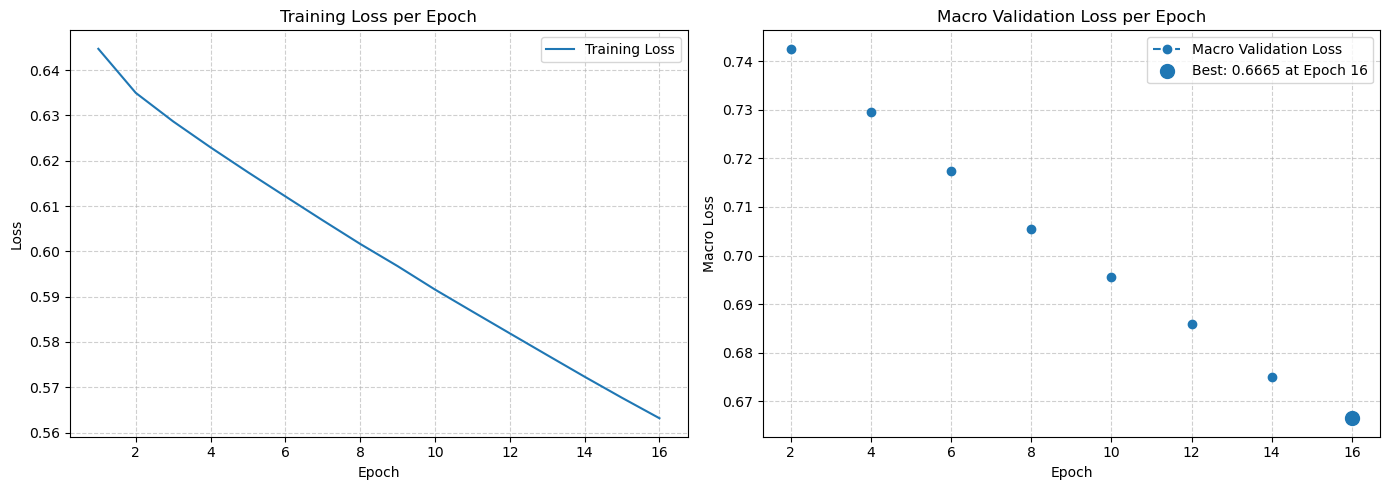

578/578 [==============================] - 183s 317ms/step - loss: 0.5632 - val_loss: 0.6665 - val_loss_macro: 0.6665
Epoch 17/50
255/578 [============>.................] - ETA: 59s - loss: 0.5594

KeyboardInterrupt: 

In [12]:
# ======================================
# Cell 5b — Main Training Run (uses train_one_model)
# ======================================
import os
import tensorflow as tf

# Use hyperparameters from Cell 3
RUN_WINDOW_SIZE = WINDOW_SIZE
RUN_STRIDE      = STRIDE
RUN_EPOCHS      = EPOCHS

# Run the unified training pipeline
run_name = "main_pitm"
model, history = train_one_model(
    run_name=run_name,
    window_size=RUN_WINDOW_SIZE,
    embed_dim=EMBED_DIM,
    num_layers=NUM_LAYERS,
    batch_per_device=BATCH_PER_DEVICE,
    learning_rate=LR,
    lambda_phys=LAMBDA_PHYS,
    do_plot=True
)

# Save final weights (optional, as in your original code)
MODEL_WEIGHTS_FINAL = "checkpoints/main_pitm_final_weights.h5"
model.save_weights(MODEL_WEIGHTS_FINAL)
print(f"✅ Saved FINAL run weights → {MODEL_WEIGHTS_FINAL}")
print(f"Best model was saved to → {BEST_CKPT}")


In [10]:
# ==========================================================
# Cell 6a — Testing Setup (Group-Conditioned) [FIXED]
# ==========================================================
import os, json, joblib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

# ----- Load GLOBAL scalers ----
# Per-group scalers are loaded inside predict_cell
feature_scaler = joblib.load(os.path.join("scalers", "feature_scaler.pkl"))
static_scaler  = joblib.load(os.path.join("scalers", "static_scaler.pkl"))
with open(os.path.join("scalers", "time_stats.json"), "r") as f: time_stats = json.load(f)
P95_T  = float(time_stats["p95_t"]); P95_DT = float(time_stats["p95_dt"])
T_MIN = 10.0; T_MAX = 50.0

# ----- Constants -----
PRED_BATCH  = 1024
SCALE_DELTA = 1e5 # Make sure this matches Cell 3

# ----- ⭐️ FIX 1: Make Cell 6a self-contained ⭐️ -----
# This function was missing, forcing Cell 6a to rely on
# a global function from Cell 5a, which is fragile.
def _make_time_channels_np(Time_s):
    t = np.asarray(Time_s, np.float64).flatten(); elapsed = t - t[0]; dt = np.diff(t, prepend=t[0])
    # This now correctly uses the P95_T and P95_DT loaded at the top of THIS cell
    t_abs_norm = np.clip(elapsed / max(P95_T,  1e-12), 0.0, 4.0)
    dt_norm = np.clip(dt / max(P95_DT, 1e-12), 0.0, 4.0)
    return t_abs_norm.astype(np.float64), dt_norm.astype(np.float64)
# ----- (End of Fix 1) -----


# ----- Helpers (unchanged) -----
def nearest_indices(ts_dense, t_sparse):
    ts = np.asarray(ts_dense, np.float64); te = np.asarray(t_sparse, np.float64); idx = np.searchsorted(ts, te); idx = np.clip(idx, 0, len(ts)-1); left = np.maximum(idx - 1, 0); take_left = (idx > 0) & (np.abs(ts[left] - te) <= np.abs(ts[idx] - te)); idx[take_left] = left[take_left]; return idx


# ----- ⭐️ FIX 2: Use the CORRECT version of load_numpy_series ⭐️ -----
# The old one in Cell 6a was outdated. This is the correct
# one from Cell 5a, which includes the _positive_deltas_scaled_np helper.

def _positive_deltas_scaled_np(Q_norm): 
    """ Helper just for the function below """
    Q_norm = np.asarray(Q_norm, np.float64).flatten()
    if Q_norm.size < 2: return np.zeros(0, np.float64)
    dq_norm = np.maximum(Q_norm[1:] - Q_norm[:-1], 0.0)
    dq_scaled = dq_norm * SCALE_DELTA
    return dq_scaled.astype(np.float64)

def load_numpy_series(file_name):
    d = load_mat(file_name); SOC = np.asarray(d["SOC_p"], np.float64).flatten(); V = np.asarray(d["V_cum_p"], np.float64).flatten(); T = np.asarray(d["Temp_cum_p"], np.float64).flatten(); Cr = np.asarray(d["C_rate_profile"], np.float64).flatten(); t_s = np.asarray(d["Time_s_p"], np.float64).flatten()
    Bat = float(np.asarray(d["Bat_cap_profile"]).reshape(-1)[0]); Rch = float(np.asarray(d["R_ch_profile"]).reshape(-1)[0]); Vmx = float(np.asarray(d["V_max_profile"]).reshape(-1)[0]); Vmn = float(np.asarray(d["V_min_profile"]).reshape(-1)[0]); Cap_Nom = float(np.asarray(d["Cap_Nom"]).reshape(-1)[0]) if "Cap_Nom" in d else 1.0
    Qe_norm = np.asarray(d["Q_exp_p"], np.float64).flatten(); Qp_norm = np.asarray(d["Q_total_p"], np.float64).flatten()
    
    # This call now safely uses the helper from Fix 1
    t_abs_norm, dt_norm = _make_time_channels_np(t_s); 
    
    V_norm = np.clip((V - Vmn) / max(Vmx - Vmn, 1e-6), -1.0, 2.0); T_norm = np.clip((T - T_MIN) / (T_MAX - T_MIN), -1.0, 2.0)
    N = min(SOC.size, V_norm.size, T_norm.size, Cr.size, t_abs_norm.size, dt_norm.size)
    
    # This returns the FULL dictionary, including the 'dq_' keys
    return { 
        "SOC": SOC[:N], "V_norm": V_norm[:N], "T_norm": T_norm[:N], 
        "Cr": Cr[:N], "t_abs_norm": t_abs_norm[:N], "dt_norm": dt_norm[:N], 
        "static": np.array([Bat, Rch, Vmx, Vmn], dtype=np.float32), 
        "Cap_Nom": Cap_Nom, 
        "Q_exp_norm": Qe_norm, "Q_total_norm": Qp_norm, 
        "dq_exp_scaled": _positive_deltas_scaled_np(Qe_norm), 
        "dq_pb_scaled":  _positive_deltas_scaled_np(Qp_norm), 
        "N": N 
    }
# ----- (End of Fix 2) -----


# --- ⭐️ MODIFIED: predict_cell now finds and passes group_id ⭐️ ---
def predict_cell(model, file_name, window_size, stride):
    
    # --- NEW: Get group_id and per-group scaler ---
    delta_scaler_group = None
    group_id = -1
    group_name = ""
    if file_name in FILE_TO_GROUP_MAP:
        group_name = FILE_TO_GROUP_MAP[file_name]
        if group_name in GROUP_TO_ID_MAP:
            group_id = GROUP_TO_ID_MAP[group_name]
        else:
            print(f"FATAL: (Testing {file_name}) Group '{group_name}' not in GROUP_TO_ID_MAP.")
            return (np.array([]),)*8
        
        scaler_path = os.path.join("scalers", f"delta_scaler_{group_name}.pkl")
        try:
            delta_scaler_group = joblib.load(scaler_path)
            print(f"  (Testing {file_name}: using '{group_name}' scaler, ID: {group_id})")
        except Exception as e:
            print(f"FATAL: (Testing {file_name}) Could not load scaler at {scaler_path}: {e}")
            return (np.array([]),)*8
    else:
        print(f"FATAL: (Testing {file_name}) File not in FILE_TO_GROUP_MAP (Cell 1).")
        return (np.array([]),)*8
    # --- END NEW ---
    
    # (Prepare input data - unchanged)
    p = load_numpy_series(file_name) 
    # --- ⭐️ MODIFICATION: Stack 6 features (SOC, V, T, t, dt, Cr) ---
    rows6 = np.stack([p["SOC"], p["V_norm"], p["T_norm"], p["t_abs_norm"], p["dt_norm"], p["Cr"]], axis=1)
    # --- ⭐️ MODIFICATION: Placeholder is (N, 7) for scaler ---
    rows7_placeholder = np.concatenate([rows6, np.zeros((rows6.shape[0], 1), np.float64)], axis=1)
    # --- ⭐️ MODIFICATION: Take first 6 scaled features ---
    rows_scaled = feature_scaler.transform(rows7_placeholder).astype(np.float32)[:, :6]
    # --- ⭐️ MODIFICATION: cr_seq removed ---
    win_pos = np.linspace(0, 1, window_size, dtype=np.float32).reshape(-1, 1); static_vec = p["static"].astype(np.float32).reshape(1, -1)
    ends = np.arange(window_size, p["N"] + 1, stride, dtype=np.int64); num = ends.size
    if num == 0: return (np.array([]),)*8

    # --- ⭐️ MODIFICATION: dyn_win is (N_win, T, 7) ---
    dyn_win = np.asarray([np.concatenate([rows_scaled[e-window_size:e, :], win_pos], axis=1) for e in ends], dtype=np.float32)
    # --- ⭐️ MODIFICATION: cr_win removed ---
    static_scaled = static_scaler.transform(static_vec).astype(np.float32); st_win = np.repeat(static_scaled, num, axis=0)
    
    # --- ⭐️ NEW: Create the group_id input array ---
    # It must be repeated for every window in the batch
    # group_id_arr = np.full(shape=(num,), fill_value=group_id, dtype=np.int32)
    group_id_arr = np.full(shape=(num, 1), fill_value=group_id, dtype=np.int32)
    # ---

    # --- ⭐️ MODIFIED: Model prediction (pass 3 inputs) ---
    y_hat_norm = model.predict(
        (dyn_win, st_win, group_id_arr),
        batch_size=PRED_BATCH,
        verbose=0
    ).reshape(-1, 1)


    #     # --- ⭐️ NEW: Create the group_id input array ---
    # group_id_arr = np.full(shape=(num, 1), fill_value=group_id, dtype=np.int32)

    # # --- ⭐️ NEW: Batched prediction to avoid large GPU transfers ---
    # preds_list = []
    # for start_idx in range(0, num, PRED_BATCH):
    #     end_idx = min(start_idx + PRED_BATCH, num)

    #     batch_dyn = dyn_win[start_idx:end_idx]
    #     batch_st  = st_win[start_idx:end_idx]
    #     batch_gid = group_id_arr[start_idx:end_idx]

    #     batch_pred = model.predict(
    #         (batch_dyn, batch_st, batch_gid),
    #         batch_size=(end_idx - start_idx),
    #         verbose=0
    #     )

    #     preds_list.append(batch_pred.reshape(-1, 1))

    # y_hat_norm = np.concatenate(preds_list, axis=0)  # shape (num, 1)


    # (Inverse transform is unchanged, uses the per-group scaler)
    dq_hat_scaled_norm = delta_scaler_group.inverse_transform(y_hat_norm).flatten()
    dq_hat_norm = np.maximum(dq_hat_scaled_norm / SCALE_DELTA, 0.0)
    q_hat_norm = np.cumsum(dq_hat_norm) # Output is NORMALIZED cumulative loss

    # (Get ground truth data - unchanged)
    dmat = load_mat(file_name) 
    Time_s = np.asarray(dmat["Time_s_p"], np.float64).flatten()
    t_exp = np.asarray(dmat["t_exp"], np.float64).flatten() if "t_exp" in dmat else np.array([])
    Cap_Nom = p["Cap_Nom"]
    q_exp_norm = p["Q_exp_norm"]
    Q_total_norm = p["Q_total_norm"]
    dq_pb_norm = np.maximum(np.diff(Q_total_norm, prepend=Q_total_norm[0]), 0.0)
    q_pb_norm = np.cumsum(dq_pb_norm)
    
    L = len(q_hat_norm)
    if L == 0: return (np.array([]),)*8
    t_dense = Time_s[ends-1]
    q_exp_norm_d = q_exp_norm[ends-1]
    q_pb_norm_d = q_pb_norm[ends-1]

    return t_dense, q_exp_norm_d, q_pb_norm_d, q_hat_norm, Cap_Nom, Time_s, t_exp 

# --- ⭐️ MODIFICATION: Added 'do_plot=True' argument ---
def evaluate_model_on_test(model, window_size, stride, plot_suffix="", do_plot=True):
    os.makedirs("plots", exist_ok=True)
    results = []

    for fn in tqdm(TEST_FILES, desc="Evaluating test cells", ncols=90):
        # This call now uses the MODIFIED predict_cell
        t_dense, q_exp_norm_d, q_pb_norm_d, q_hat_norm_d, cap_nom, Time_s_full, t_exp = predict_cell(model, fn, window_size, stride)

        if t_dense.size == 0: print(f"Warning: no windows for {fn}"); continue

        ts_dense = t_dense
        t_exp_use = t_exp[(t_exp >= ts_dense[0]) & (t_exp <= ts_dense[-1])]
        idx = nearest_indices(ts_dense, t_exp_use)
        if idx.size == 0: print(f"Warning: no matching experimental time points for {fn}"); continue

        Q_exp_norm_stamp = q_exp_norm_d[idx]
        Q_pb_norm_stamp = q_pb_norm_d[idx]
        Q_pred_norm_stamp = q_hat_norm_d[idx]
        
        Q_exp_n = Q_exp_norm_stamp.copy()
        Q_pred_n = Q_pred_norm_stamp.copy()
        Q_pb_n = Q_pb_norm_stamp.copy()

        # (Metrics calculation is unchanged)
        mse_pitm_norm = float(np.mean((Q_exp_n - Q_pred_n)**2)) 
        denom_norm = float(np.sum(Q_exp_n**2))
        rsep_pitm = 100.0 * np.sqrt(np.sum((Q_exp_n - Q_pred_n)**2) / denom_norm) if denom_norm > 1e-12 else np.nan
        mask = np.abs(Q_exp_n) > 1e-9 
        mape_pitm = 100.0 * np.mean(np.abs((Q_exp_n[mask] - Q_pred_n[mask]) / Q_exp_n[mask])) if np.any(mask) else np.nan
        mse_pb_norm = float(np.mean((Q_exp_n - Q_pb_n)**2)) 
        rsep_pb = 100.0 * np.sqrt(np.sum((Q_exp_n - Q_pb_n)**2) / denom_norm) if denom_norm > 1e-12 else np.nan
        mape_pb = 100.0 * np.mean(np.abs((Q_exp_n[mask] - Q_pb_n[mask]) / Q_pb_n[mask])) if np.any(mask) else np.nan
        mse_pitm_abs = mse_pitm_norm * (cap_nom**2)
        mse_pb_abs = mse_pb_norm * (cap_nom**2)
        
        results.append((os.path.basename(fn), mse_pitm_abs, mape_pitm, rsep_pitm, mse_pb_abs, mape_pb, rsep_pb))

        # --- ⭐️ MODIFICATION: Plotting is now conditional ---
        if do_plot:
            plt.figure(figsize=(6.8, 3.2))
            cap_nom_safe = max(cap_nom, 1e-6)
            plt.scatter(t_exp_use / 3600.0, 100.0 * Q_exp_norm_stamp, s=18, label="Experimental", zorder=3)
            plt.plot(t_dense / 3600.0, 100.0 * q_pb_norm_d, lw=1.2, label="PB-ROM", zorder=2)
            plt.plot(t_dense / 3600.0, 100.0 * q_hat_norm_d, lw=1.8, label="PITM", zorder=2)
            plt.xlabel("Time (h)"); plt.ylabel("Capacity degradation (%)"); plt.title(os.path.basename(fn))
            plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
            suffix = f"_{plot_suffix}" if plot_suffix else ""; out_pct = f"plots/{os.path.basename(fn).replace('.mat', '')}_pred_pct{suffix}.png"
            plt.savefig(out_pct, dpi=300); plt.show(); plt.close()
            print(f"Saved → {out_pct}")
        # --- End of modification ---

    print("\n📊 PITM Testing Results (per cell)")
    for name, mse_pitm, mape_pitm, rsep_pitm, mse_pb, mape_pb, rsep_pb in results:
        print(f"  {name:35s}   "
              f"[PITM] MSE={mse_pitm:.3e} RSEP={rsep_pitm:.2f}% MAPE={mape_pitm:.2f}%    " 
              # f"[PB] MSE={mse_pb:.3e} RSEP={rsep_pb:.2f}% MAPE={mape_pb:.2f}%"
        )    

    return results

print("✅ Cell 6a (Group-Conditioned) testing pipeline ready.")

✅ Cell 6a (Group-Conditioned) testing pipeline ready.


Rebuilding v4 model architecture...
✅ Loaded BEST run weights from checkpoints/main_pitm_best_macro.h5


Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


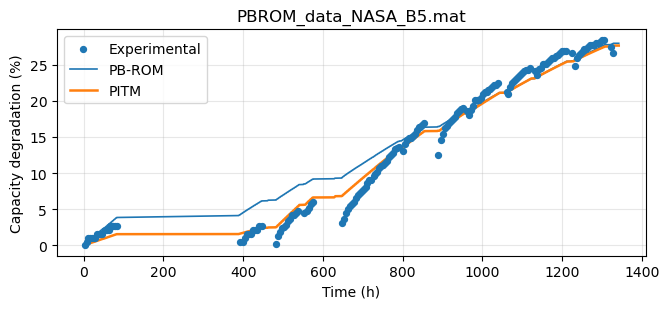

Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:14<00:00, 14.14s/it]

Saved → plots/PBROM_data_NASA_B5_pred_pct_best_model.png

📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=5.538e-04 RSEP=6.89% MAPE=25.68%    [PB] MSE=2.150e-03 RSEP=13.57% MAPE=19.97%


In [9]:
# ======================================
# Cell 6b — Test the Best Model
# ======================================

# --- Load the BEST checkpoint from training ---
MODEL_TO_TEST = os.path.join("checkpoints", "main_pitm_best_macro.h5")
# MODEL_TO_TEST = os.path.join("checkpoints", "main_pitm_final_weights.h5")

if not os.path.exists(MODEL_TO_TEST):
    print(f"⚠️ Warning: Best checkpoint not found at {MODEL_TO_TEST}.")
    print("Falling back to final weights. Re-run 5b if this is wrong.")
    MODEL_TO_TEST = "checkpoints/main_pitm_final_weights.h5"
    if not os.path.exists(MODEL_TO_TEST):
        raise FileNotFoundError("No model weights found to test.")

# --- Use the same hyperparams as training ---
RUN_WINDOW_SIZE = WINDOW_SIZE
RUN_STRIDE = STRIDE

# --- Rebuild the EXACT same architecture (v4) ---
print("Rebuilding v4 model architecture...")
model = build_pitm_model(
    window_size=RUN_WINDOW_SIZE,
    num_groups=NUM_GROUPS,  # <-- From Cell 1
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT # Note: dropout is inactive during inference
)

# Load the trained weights
model.load_weights(MODEL_TO_TEST)
print(f"✅ Loaded BEST run weights from {MODEL_TO_TEST}")

# --- Run evaluation using the new (Cell 6a) pipeline ---
_ = evaluate_model_on_test(
    model, 
    window_size=RUN_WINDOW_SIZE, 
    stride=RUN_STRIDE, 
    plot_suffix="best_model"
)

In [8]:
# # ===============================================
# # Cell 10a — Random Search (Stage 2) Definitions
# # (tuned around the current best config)
# # ===============================================
# import numpy as np

# # --- Number of random runs ---
# # Increase this (e.g. 10–20) once you're happy with the space
# N_RANDOM_RUNS = 20  # or 10+ for a more thorough search

# RANDOM_SEARCH_SPACE_STAGE2 = {
#     # Discrete choices (random.choice)
#     "window_size":  [10, 50, 100, 200, 400],       # around 70
#     "batch_size":   [64, 256, 512, 768, 1024],        # around 512 (watch GPU memory)
#     "num_layers":   [1, 2, 3, 4, 5],              # shallow to moderately deep
#     "embed_dim":    [32, 64, 96, 128],           # around 64

#     # Continuous ranges (random.uniform / log-uniform)
#     "lambda_phys":  [0.0, 1.1],             # narrow band around ~0.67
#     "learning_rate": [1e-8, 3e-4],          # around 8e-7, still some room
# }

# print(f"✅ Stage 2 Random Search defined: {N_RANDOM_RUNS} total runs.")
# print(f"   window_size candidates:   {RANDOM_SEARCH_SPACE_STAGE2['window_size']}")
# print(f"   batch_size candidates:    {RANDOM_SEARCH_SPACE_STAGE2['batch_size']}")
# print(f"   num_layers candidates:    {RANDOM_SEARCH_SPACE_STAGE2['num_layers']}")
# print(f"   embed_dim candidates:     {RANDOM_SEARCH_SPACE_STAGE2['embed_dim']}")
# print(f"   lambda_phys range:        {RANDOM_SEARCH_SPACE_STAGE2['lambda_phys']}")
# print(f"   learning_rate log-range:  [{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][0]:.1e}, "
#       f"{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][1]:.1e}]")
# print(f"   Using the unified training pipeline (train_one_model).")


✅ Stage 2 Random Search defined: 20 total runs.
   window_size candidates:   [10, 50, 100, 200, 400]
   batch_size candidates:    [64, 256, 512, 768, 1024]
   num_layers candidates:    [1, 2, 3, 4, 5]
   embed_dim candidates:     [32, 64, 96, 128]
   lambda_phys range:        [0.0, 1.1]
   learning_rate log-range:  [1.0e-08, 3.0e-04]
   Using the unified training pipeline (train_one_model).


In [9]:
# # ===============================================
# # Cell 10b — Random Search Execution (using train_one_model)
# # ===============================================
# import numpy as np, tensorflow as tf, os, csv, random

# # Helper to write CSV
# def _write_csv_row(path, header, row_dict):
#     write_header = not os.path.exists(path)
#     with open(path, "a", newline="") as f:
#         w = csv.DictWriter(f, fieldnames=header)
#         if write_header:
#             w.writeheader()
#         w.writerow(row_dict)

# # Reset any leftover graphs
# tf.keras.backend.clear_session()

# # Results CSV
# ABLATION_CSV_PATH = os.path.join("ablation", "random_search_stage2_results.csv")
# if os.path.exists(ABLATION_CSV_PATH):
#     os.remove(ABLATION_CSV_PATH)

# CSV_HEADER = [
#     "run_num",
#     "window_size",
#     "lambda_phys",
#     "batch_size",
#     "learning_rate",
#     "num_layers",
#     "embed_dim",
#     "avg_rsep_pitm"
# ]

# for run_num in range(N_RANDOM_RUNS):
#     tf.keras.backend.clear_session()

#     # 🔑 Make Python & NumPy RNG state different per run
#     random.seed(SEED + run_num)
#     np.random.seed(SEED + run_num)

#     # --- Sample hyperparameters ---
#     run_ws = random.choice(RANDOM_SEARCH_SPACE_STAGE2["window_size"])
#     run_lp = random.uniform(*RANDOM_SEARCH_SPACE_STAGE2["lambda_phys"])
#     run_bs = random.choice(RANDOM_SEARCH_SPACE_STAGE2["batch_size"])

#     lr_min, lr_max = RANDOM_SEARCH_SPACE_STAGE2["learning_rate"]
#     run_lr = 10 ** random.uniform(np.log10(lr_min), np.log10(lr_max))

#     run_layers = random.choice(RANDOM_SEARCH_SPACE_STAGE2["num_layers"])
#     run_embed  = random.choice(RANDOM_SEARCH_SPACE_STAGE2["embed_dim"])

#     print("\n" + "=" * 50)
#     print(f"RANDOM SEARCH RUN {run_num+1} / {N_RANDOM_RUNS}")
#     print(f"  window_size   = {run_ws}")
#     print(f"  lambda_phys   = {run_lp:.4f}")
#     print(f"  batch_size    = {run_bs}")
#     print(f"  learning_rate = {run_lr:.2e}")
#     print(f"  num_layers    = {run_layers}")
#     print(f"  embed_dim     = {run_embed}")
#     print("=" * 50)

#     # Fixed seed for all runs (as agreed)
#     # tf.keras.utils.set_random_seed(SEED)

#     # Unique run name for this random-search trial
#     run_name = f"rs2_run{run_num+1}"

#     # --- Train model using EXACT same pipeline as main training ---
#     model, history = train_one_model(
#         run_name=run_name,
#         window_size=run_ws,
#         embed_dim=run_embed,
#         num_layers=run_layers,
#         batch_per_device=run_bs,
#         learning_rate=run_lr,
#         lambda_phys=run_lp,
#         do_plot=False  # no live plots during random search
#     )

#     # BEST_CKPT was set inside train_one_model for this run_name
#     # We now load that checkpoint before evaluating
#     if os.path.exists(BEST_CKPT):
#         print(f"Loading BEST checkpoint for evaluation: {BEST_CKPT}")
#         model.load_weights(BEST_CKPT)
#     else:
#         print(f"WARNING: BEST_CKPT not found at {BEST_CKPT}. Using final weights.")

#     # --- Evaluate on TEST set using the shared testing pipeline ---
#     test_results = evaluate_model_on_test(
#         model,
#         window_size=run_ws,
#         stride=STRIDE,
#         plot_suffix=run_name,
#         do_plot=False
#     )

#     rsep_values = [res[3] for res in test_results if np.isfinite(res[3])]
#     avg_rsep_pitm = np.mean(rsep_values) if rsep_values else np.nan
#     print(f"[RandomSearch] Run {run_num+1} → avg_rsep_pitm={avg_rsep_pitm:.4f}")

#     row_dict = {
#         "run_num": run_num+1,
#         "window_size": run_ws,
#         "lambda_phys": run_lp,
#         "batch_size": run_bs,
#         "learning_rate": run_lr,
#         "num_layers": run_layers,
#         "embed_dim": run_embed,
#         "avg_rsep_pitm": avg_rsep_pitm
#     }
#     _write_csv_row(ABLATION_CSV_PATH, CSV_HEADER, row_dict)

# print("\n✅ Stage 2 Random Search complete.")
# print(f"Results saved to {ABLATION_CSV_PATH}")



RANDOM SEARCH RUN 1 / 20
  window_size   = 10
  lambda_phys   = 0.0275
  batch_size    = 512
  learning_rate = 1.25e-07
  num_layers    = 2
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 25s 8ms/step - loss: 0.2026
Epoch 2/50
1153/1156 [============================>.] - ETA: 0s - loss: 0.1995  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=8.093e-03 RSEP=26.34% MAPE=34.96%    
[RandomSearch] Run 1 → avg_rsep_pitm=26.3353

RANDOM SEARCH RUN 2 / 20
  window_size   = 10
  lambda_phys   = 0.3147
  batch_size    = 256
  learning_rate = 1.97e-04
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 2,311
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,311, batch=256)
Epoch 1/50
2311/2311 [==============================] - 41s 9ms/step - loss: 0.1192
Epoch 2/50
2310/2311 [============================>.] - ETA: 0s - loss: 0.0629  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.121e-03 RSEP=9.80% MAPE=31.73%    
[RandomSearch] Run 2 → avg_rsep_pitm=9.8030

RANDOM SEARCH RUN 3 / 20
  window_size   = 200
  lambda_phys   = 0.5720
  batch_size    = 64
  learning_rate = 6.18e-08
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=200, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,259 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,259): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:10<00:00, 10.57s/it]


  Created 591,258 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,258
X_dyn shape: (591258, 200, 7)
X_st shape:  (591258, 4)
X_gid shape: (591258, 1)
y_train shape: (591258, 2)
weights shape: (591258,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,258
  Steps per epoch: 9,239
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,259 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,239, batch=64)
Epoch 1/50
9239/9239 [==============================] - 145s 14ms/step - loss: 0.4315
Epoch 2/50
9236/9239 [============================>.] - ETA: 0s - loss: 0.3154  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:16<00:00, 16.37s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.165e-02 RSEP=31.60% MAPE=40.06%    
[RandomSearch] Run 3 → avg_rsep_pitm=31.5970

RANDOM SEARCH RUN 4 / 20
  window_size   = 100
  lambda_phys   = 0.4595
  batch_size    = 512
  learning_rate = 2.33e-08
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 1,155
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,155, batch=512)
Epoch 1/50
1155/1155 [==============================] - 42s 18ms/step - loss: 0.3098
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 0.3075  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:12<00:00, 12.93s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.094e-02 RSEP=42.36% MAPE=51.73%    
[RandomSearch] Run 4 → avg_rsep_pitm=42.3602

RANDOM SEARCH RUN 5 / 20
  window_size   = 10
  lambda_phys   = 0.4400
  batch_size    = 1024
  learning_rate = 4.24e-06
  num_layers    = 2
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50
578/578 [==============================] - 20s 8ms/step - loss: 0.2624
Epoch 2/50
577/578 [============================>.] - ETA: 0s - loss: 0.2462  → STREAM: 1 files, 5

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.15s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=9.654e-04 RSEP=9.10% MAPE=30.39%    
[RandomSearch] Run 5 → avg_rsep_pitm=9.0958

RANDOM SEARCH RUN 6 / 20
  window_size   = 100
  lambda_phys   = 0.0688
  batch_size    = 1024
  learning_rate = 1.07e-06
  num_layers    = 3
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.42s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50
578/578 [==============================] - 44s 35ms/step - loss: 0.3664
Epoch 2/50
577/578 [============================>.] - ETA: 0s - loss: 0.3522  → STREAM: 1 files,

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:11<00:00, 11.87s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=5.553e-04 RSEP=6.90% MAPE=25.68%    
[RandomSearch] Run 6 → avg_rsep_pitm=6.8986

RANDOM SEARCH RUN 7 / 20
  window_size   = 400
  lambda_phys   = 0.3470
  batch_size    = 1024
  learning_rate = 1.53e-05
  num_layers    = 3
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,059 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,059): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:11<00:00, 11.82s/it]


  Created 591,058 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,058
X_dyn shape: (591058, 400, 7)
X_st shape:  (591058, 4)
X_gid shape: (591058, 1)
y_train shape: (591058, 2)
weights shape: (591058,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,058
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,059 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50
578/578 [==============================] - 125s 169ms/step - loss: 0.3153
Epoch 2/50
578/578 [==============================] - ETA: 0s - loss: 0.2905  → STREAM: 1 file

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:46<00:00, 46.53s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=5.600e-04 RSEP=6.93% MAPE=30.39%    
[RandomSearch] Run 7 → avg_rsep_pitm=6.9276

RANDOM SEARCH RUN 8 / 20
  window_size   = 10
  lambda_phys   = 0.3788
  batch_size    = 64
  learning_rate = 2.81e-07
  num_layers    = 5
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 9,242
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,242, batch=64)
Epoch 1/50
9242/9242 [==============================] - 150s 13ms/step - loss: 0.3379
Epoch 2/50
9239/9242 [============================>.] - ETA: 0s - loss: 0.3296  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.637e-03 RSEP=11.84% MAPE=32.20%    
[RandomSearch] Run 8 → avg_rsep_pitm=11.8427

RANDOM SEARCH RUN 9 / 20
  window_size   = 200
  lambda_phys   = 0.9413
  batch_size    = 512
  learning_rate = 7.14e-06
  num_layers    = 2
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=200, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,259 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,259): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:10<00:00, 10.07s/it]


  Created 591,258 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,258
X_dyn shape: (591258, 200, 7)
X_st shape:  (591258, 4)
X_gid shape: (591258, 1)
y_train shape: (591258, 2)
weights shape: (591258,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,258
  Steps per epoch: 1,155
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,259 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,155, batch=512)
Epoch 1/50
1155/1155 [==============================] - 56s 32ms/step - loss: 0.3125
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 0.2906  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:16<00:00, 16.82s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.545e-03 RSEP=14.77% MAPE=43.25%    
[RandomSearch] Run 9 → avg_rsep_pitm=14.7683

RANDOM SEARCH RUN 10 / 20
  window_size   = 50
  lambda_phys   = 0.9223
  batch_size    = 1024
  learning_rate = 5.31e-08
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,409 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,409): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]


  Created 591,408 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,408
X_dyn shape: (591408, 50, 7)
X_st shape:  (591408, 4)
X_gid shape: (591408, 1)
y_train shape: (591408, 2)
weights shape: (591408,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,408
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,409 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50
578/578 [==============================] - 25s 14ms/step - loss: 0.7325
Epoch 2/50
577/578 [============================>.] - ETA: 0s - loss: 0.6855  → STREAM: 1 files, 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:09<00:00,  9.06s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.612e-02 RSEP=37.16% MAPE=53.40%    
[RandomSearch] Run 10 → avg_rsep_pitm=37.1625

RANDOM SEARCH RUN 11 / 20
  window_size   = 100
  lambda_phys   = 0.0600
  batch_size    = 1024
  learning_rate = 1.47e-06
  num_layers    = 3
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50
578/578 [==============================] - 43s 37ms/step - loss: 0.3888
Epoch 2/50
577/578 [============================>.] - ETA: 0s - loss: 0.3765  → STREAM: 1 files,

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=5.051e-04 RSEP=6.58% MAPE=26.14%    
[RandomSearch] Run 11 → avg_rsep_pitm=6.5792

RANDOM SEARCH RUN 12 / 20
  window_size   = 400
  lambda_phys   = 0.9385
  batch_size    = 256
  learning_rate = 1.11e-06
  num_layers    = 4
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,059 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,059): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


  Created 591,058 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,058
X_dyn shape: (591058, 400, 7)
X_st shape:  (591058, 4)
X_gid shape: (591058, 1)
y_train shape: (591058, 2)
weights shape: (591058,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,058
  Steps per epoch: 2,309
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,059 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,309, batch=256)
Epoch 1/50
2309/2309 [==============================] - 204s 77ms/step - loss: 0.4686
Epoch 2/50
2309/2309 [==============================] - ETA: 0s - loss: 0.4485  → STREAM: 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:59<00:00, 59.10s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.934e-03 RSEP=12.87% MAPE=43.49%    
[RandomSearch] Run 12 → avg_rsep_pitm=12.8740

RANDOM SEARCH RUN 13 / 20
  window_size   = 50
  lambda_phys   = 0.4828
  batch_size    = 512
  learning_rate = 1.45e-06
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,409 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,409): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


  Created 591,408 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,408
X_dyn shape: (591408, 50, 7)
X_st shape:  (591408, 4)
X_gid shape: (591408, 1)
y_train shape: (591408, 2)
weights shape: (591408,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,408
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,409 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 48s 19ms/step - loss: 0.4939
Epoch 2/50
1156/1156 [==============================] - ETA: 0s - loss: 0.4748  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:09<00:00,  9.07s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.139e-03 RSEP=9.88% MAPE=31.95%    
[RandomSearch] Run 13 → avg_rsep_pitm=9.8794

RANDOM SEARCH RUN 14 / 20
  window_size   = 10
  lambda_phys   = 1.0867
  batch_size    = 256
  learning_rate = 4.69e-08
  num_layers    = 3
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 2,311
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,311, batch=256)
Epoch 1/50
2311/2311 [==============================] - 40s 9ms/step - loss: 0.3546
Epoch 2/50
2311/2311 [==============================] - ETA: 0s - loss: 0.3448  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.26s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.731e-03 RSEP=15.30% MAPE=39.77%    
[RandomSearch] Run 14 → avg_rsep_pitm=15.2979

RANDOM SEARCH RUN 15 / 20
  window_size   = 400
  lambda_phys   = 0.0126
  batch_size    = 1024
  learning_rate = 2.23e-07
  num_layers    = 5
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 1024 | Global batch: 1024

--- ⚙️ Pass 1.5: Building training arrays (window_size=400, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,059 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,059): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:11<00:00, 11.73s/it]


  Created 591,058 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,058
X_dyn shape: (591058, 400, 7)
X_st shape:  (591058, 4)
X_gid shape: (591058, 1)
y_train shape: (591058, 2)
weights shape: (591058,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,058
  Steps per epoch: 578
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,059 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 578, batch=1024)
Epoch 1/50


ResourceExhaustedError: Graph execution error:

Out of memory while trying to allocate 655360000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.54GiB
              constant allocation:        28B
        maybe_live_out allocation:    2.12GiB
     preallocated temp allocation:  100.00MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    4.76GiB
Peak buffers:
	Buffer 1:
		Size: 1.22GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f16[1024,4,400,400]
		==========================

	Buffer 2:
		Size: 1.22GiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f16[1024,4,400,400]
		==========================

	Buffer 3:
		Size: 1.22GiB
		Operator: op_type="SelectV2" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/dropout/dropout/SelectV2"
		XLA Label: fusion
		Shape: f16[1024,4,400,400]
		==========================

	Buffer 4:
		Size: 625.00MiB
		Operator: op_type="SelectV2" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/dropout/dropout/SelectV2"
		XLA Label: fusion
		Shape: pred[1024,4,400,400]
		==========================

	Buffer 5:
		Size: 100.00MiB
		Operator: op_type="AddV2" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/value/add"
		XLA Label: fusion
		Shape: f16[1024,4,400,32]
		==========================

	Buffer 6:
		Size: 100.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f16[1024,400,128]
		==========================

	Buffer 7:
		Size: 100.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: transpose
		Shape: f16[1024,400,4,32]
		==========================

	Buffer 8:
		Size: 100.00MiB
		Operator: op_type="Einsum" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/einsum_1/Einsum"
		XLA Label: transpose
		Shape: f16[1024,400,4,32]
		==========================

	Buffer 9:
		Size: 100.00MiB
		XLA Label: fusion
		Shape: f16[409600,128]
		==========================

	Buffer 10:
		Size: 64.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[4,32,128]
		==========================

	Buffer 11:
		Size: 64.0KiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[128,4,32]
		==========================

	Buffer 12:
		Size: 32.0KiB
		Operator: op_type="Cast" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/value/einsum/Einsum/Cast"
		XLA Label: fusion
		Shape: f16[16384]
		==========================

	Buffer 13:
		Size: 32.0KiB
		Operator: op_type="Cast" op_name="PITM_DeltaTransformer_v7_Modulated_SingleGroup/multi_head_attention_4/value/einsum/Einsum/Cast"
		XLA Label: fusion
		Shape: f16[16384]
		==========================

	Buffer 14:
		Size: 512B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[128]
		==========================

	Buffer 15:
		Size: 512B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[4,32]
		==========================


	 [[{{node cluster_252_1/xla_run}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7755404]

In [8]:
# ===============================================
# Cell 10a — Random Search (Stage 2) Definitions
# (tuned around the current best config)
# ===============================================
import numpy as np

# --- Number of random runs ---
# Increase this (e.g. 10–20) once you're happy with the space
N_RANDOM_RUNS = 20  # or 10+ for a more thorough search

RANDOM_SEARCH_SPACE_STAGE2 = {
    # Discrete choices (random.choice)
    "window_size":  [10, 50, 100, 20, 150],       # around 70
    "batch_size":   [64, 256, 512, 768, 1024],        # around 512 (watch GPU memory)
    "num_layers":   [1, 2, 3, 4, 5],              # shallow to moderately deep
    "embed_dim":    [32, 64, 96, 128],           # around 64

    # Continuous ranges (random.uniform / log-uniform)
    "lambda_phys":  [0.0, 1.1],             # narrow band around ~0.67
    "learning_rate": [1e-8, 3e-4],          # around 8e-7, still some room
}

print(f"✅ Stage 2 Random Search defined: {N_RANDOM_RUNS} total runs.")
print(f"   window_size candidates:   {RANDOM_SEARCH_SPACE_STAGE2['window_size']}")
print(f"   batch_size candidates:    {RANDOM_SEARCH_SPACE_STAGE2['batch_size']}")
print(f"   num_layers candidates:    {RANDOM_SEARCH_SPACE_STAGE2['num_layers']}")
print(f"   embed_dim candidates:     {RANDOM_SEARCH_SPACE_STAGE2['embed_dim']}")
print(f"   lambda_phys range:        {RANDOM_SEARCH_SPACE_STAGE2['lambda_phys']}")
print(f"   learning_rate log-range:  [{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][0]:.1e}, "
      f"{RANDOM_SEARCH_SPACE_STAGE2['learning_rate'][1]:.1e}]")
print(f"   Using the unified training pipeline (train_one_model).")


✅ Stage 2 Random Search defined: 20 total runs.
   window_size candidates:   [10, 50, 100, 20, 150]
   batch_size candidates:    [64, 256, 512, 768, 1024]
   num_layers candidates:    [1, 2, 3, 4, 5]
   embed_dim candidates:     [32, 64, 96, 128]
   lambda_phys range:        [0.0, 1.1]
   learning_rate log-range:  [1.0e-08, 3.0e-04]
   Using the unified training pipeline (train_one_model).


In [9]:
# ===============================================
# Cell 10b — Random Search Execution (using train_one_model)
# ===============================================
import numpy as np, tensorflow as tf, os, csv, random

# Helper to write CSV
def _write_csv_row(path, header, row_dict):
    write_header = not os.path.exists(path)
    with open(path, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=header)
        if write_header:
            w.writeheader()
        w.writerow(row_dict)

# Reset any leftover graphs
tf.keras.backend.clear_session()

# Results CSV
ABLATION_CSV_PATH = os.path.join("ablation", "random_search_stage2_results.csv")
if os.path.exists(ABLATION_CSV_PATH):
    os.remove(ABLATION_CSV_PATH)

CSV_HEADER = [
    "run_num",
    "window_size",
    "lambda_phys",
    "batch_size",
    "learning_rate",
    "num_layers",
    "embed_dim",
    "avg_rsep_pitm"
]

for run_num in range(N_RANDOM_RUNS):
    tf.keras.backend.clear_session()

    # 🔑 Make Python & NumPy RNG state different per run
    random.seed(SEED + run_num)
    np.random.seed(SEED + run_num)

    # --------------------------------------------------
    # Sample hyperparameters with a constraint:
    #   Do NOT allow any combination where 2 or 3 of
    #   {window_size=400, batch_size=1024, num_layers=5}
    #   are selected simultaneously.
    #   (At most ONE of these can be active.)
    # --------------------------------------------------
    while True:
        # Discrete hyperparameters
        run_ws = random.choice(RANDOM_SEARCH_SPACE_STAGE2["window_size"])
        run_bs = random.choice(RANDOM_SEARCH_SPACE_STAGE2["batch_size"])
        run_layers = random.choice(RANDOM_SEARCH_SPACE_STAGE2["num_layers"])
        run_embed  = random.choice(RANDOM_SEARCH_SPACE_STAGE2["embed_dim"])

        # Continuous hyperparameters
        run_lp_min, run_lp_max = RANDOM_SEARCH_SPACE_STAGE2["lambda_phys"]
        run_lp = random.uniform(run_lp_min, run_lp_max)

        lr_min, lr_max = RANDOM_SEARCH_SPACE_STAGE2["learning_rate"]
        run_lr = 10 ** random.uniform(np.log10(lr_min), np.log10(lr_max))

        # Count how many of the "heavy" settings are active
        heavy_flags = int(run_ws == 400) + int(run_bs == 1024) + int(run_layers == 5)

        # Accept only if at most ONE of them is active
        if heavy_flags <= 1:
            break
        # otherwise, resample

    print("\n" + "=" * 50)
    print(f"RANDOM SEARCH RUN {run_num+1} / {N_RANDOM_RUNS}")
    print(f"  window_size   = {run_ws}")
    print(f"  lambda_phys   = {run_lp:.4f}")
    print(f"  batch_size    = {run_bs}")
    print(f"  learning_rate = {run_lr:.2e}")
    print(f"  num_layers    = {run_layers}")
    print(f"  embed_dim     = {run_embed}")
    print("=" * 50)

    # Unique run name for this random-search trial
    run_name = f"rs2_run{run_num+1}"

    # --- Train model using EXACT same pipeline as main training ---
    model, history = train_one_model(
        run_name=run_name,
        window_size=run_ws,
        embed_dim=run_embed,
        num_layers=run_layers,
        batch_per_device=run_bs,
        learning_rate=run_lr,
        lambda_phys=run_lp,
        do_plot=False  # no live plots during random search
    )

    # BEST_CKPT was set inside train_one_model for this run_name
    # We now load that checkpoint before evaluating
    if os.path.exists(BEST_CKPT):
        print(f"Loading BEST checkpoint for evaluation: {BEST_CKPT}")
        model.load_weights(BEST_CKPT)
    else:
        print(f"WARNING: BEST_CKPT not found at {BEST_CKPT}. Using final weights.")

    # --- Evaluate on TEST set using the shared testing pipeline ---
    test_results = evaluate_model_on_test(
        model,
        window_size=run_ws,
        stride=STRIDE,
        plot_suffix=run_name,
        do_plot=False
    )

    rsep_values = [res[3] for res in test_results if np.isfinite(res[3])]
    avg_rsep_pitm = np.mean(rsep_values) if rsep_values else np.nan
    print(f"[RandomSearch] Run {run_num+1} → avg_rsep_pitm={avg_rsep_pitm:.4f}")

    row_dict = {
        "run_num": run_num+1,
        "window_size": run_ws,
        "lambda_phys": run_lp,
        "batch_size": run_bs,
        "learning_rate": run_lr,
        "num_layers": run_layers,
        "embed_dim": run_embed,
        "avg_rsep_pitm": avg_rsep_pitm
    }
    _write_csv_row(ABLATION_CSV_PATH, CSV_HEADER, row_dict)

print("\n✅ Stage 2 Random Search complete.")
print(f"Results saved to {ABLATION_CSV_PATH}")



RANDOM SEARCH RUN 1 / 20
  window_size   = 10
  lambda_phys   = 0.2455
  batch_size    = 64
  learning_rate = 1.98e-05
  num_layers    = 3
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 9,242
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,242, batch=64)
Epoch 1/50
9242/9242 [==============================] - 108s 10ms/step - loss: 0.2426
Epoch 2/50
9242/9242 [==============================] - ETA: 0s - loss: 0.1636  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=9.861e-04 RSEP=9.19% MAPE=29.22%    
[RandomSearch] Run 1 → avg_rsep_pitm=9.1926

RANDOM SEARCH RUN 2 / 20
  window_size   = 10
  lambda_phys   = 0.4069
  batch_size    = 512
  learning_rate = 1.34e-05
  num_layers    = 2
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 24s 7ms/step - loss: 0.2891
Epoch 2/50
1152/1156 [============================>.] - ETA: 0s - loss: 0.2629  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.300e-03 RSEP=10.55% MAPE=30.66%    
[RandomSearch] Run 2 → avg_rsep_pitm=10.5537

RANDOM SEARCH RUN 3 / 20
  window_size   = 10
  lambda_phys   = 0.1102
  batch_size    = 256
  learning_rate = 2.93e-05
  num_layers    = 1
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 2,311
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,311, batch=256)
Epoch 1/50
2311/2311 [==============================] - 21s 5ms/step - loss: 0.1264
Epoch 2/50
2311/2311 [==============================] - ETA: 0s - loss: 0.1003  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=4.262e-04 RSEP=6.04% MAPE=24.61%    
[RandomSearch] Run 3 → avg_rsep_pitm=6.0436

RANDOM SEARCH RUN 4 / 20
  window_size   = 100
  lambda_phys   = 0.0901
  batch_size    = 768
  learning_rate = 3.29e-07
  num_layers    = 4
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 768 | Global batch: 768

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 770
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 770, batch=768)
Epoch 1/50
770/770 [==============================] - 55s 35ms/step - loss: 0.4402
Epoch 2/50
769/770 [============================>.] - ETA: 0s - loss: 0.4312  → STREAM: 1 files, 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:13<00:00, 13.57s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=6.302e-04 RSEP=7.35% MAPE=26.50%    
[RandomSearch] Run 4 → avg_rsep_pitm=7.3492

RANDOM SEARCH RUN 5 / 20
  window_size   = 10
  lambda_phys   = 0.6980
  batch_size    = 768
  learning_rate = 4.79e-08
  num_layers    = 1
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 768 | Global batch: 768

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 771
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 771, batch=768)
Epoch 1/50
771/771 [==============================] - 15s 5ms/step - loss: 0.2247
Epoch 2/50
766/771 [============================>.] - ETA: 0s - loss: 0.2220  → STREAM: 1 files, 59

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:03<00:00,  3.79s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.745e-03 RSEP=15.34% MAPE=34.30%    
[RandomSearch] Run 5 → avg_rsep_pitm=15.3389

RANDOM SEARCH RUN 6 / 20
  window_size   = 100
  lambda_phys   = 0.6279
  batch_size    = 64
  learning_rate = 1.42e-07
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 9,240
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,240, batch=64)
Epoch 1/50
9240/9240 [==============================] - 307s 30ms/step - loss: 0.5106
Epoch 2/50
9239/9240 [============================>.] - ETA: 0s - loss: 0.4882  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.332e-03 RSEP=14.14% MAPE=32.82%    
[RandomSearch] Run 6 → avg_rsep_pitm=14.1372

RANDOM SEARCH RUN 7 / 20
  window_size   = 150
  lambda_phys   = 0.8725
  batch_size    = 512
  learning_rate = 1.83e-06
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=150, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,309 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,309): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]


  Created 591,308 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,308
X_dyn shape: (591308, 150, 7)
X_st shape:  (591308, 4)
X_gid shape: (591308, 1)
y_train shape: (591308, 2)
weights shape: (591308,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,308
  Steps per epoch: 1,155
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,309 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,155, batch=512)
Epoch 1/50
1155/1155 [==============================] - 46s 25ms/step - loss: 0.3520
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 0.2974  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:13<00:00, 13.64s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.058e-03 RSEP=13.28% MAPE=39.91%    
[RandomSearch] Run 7 → avg_rsep_pitm=13.2810

RANDOM SEARCH RUN 8 / 20
  window_size   = 10
  lambda_phys   = 0.3558
  batch_size    = 512
  learning_rate = 3.03e-06
  num_layers    = 4
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 38s 11ms/step - loss: 0.3162
Epoch 2/50
1154/1156 [============================>.] - ETA: 0s - loss: 0.2859  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.579e-03 RSEP=14.87% MAPE=32.40%    
[RandomSearch] Run 8 → avg_rsep_pitm=14.8679

RANDOM SEARCH RUN 9 / 20
  window_size   = 20
  lambda_phys   = 0.7618
  batch_size    = 512
  learning_rate = 2.71e-05
  num_layers    = 3
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=20, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,439 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,439): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.26s/it]


  Created 591,438 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,438
X_dyn shape: (591438, 20, 7)
X_st shape:  (591438, 4)
X_gid shape: (591438, 1)
y_train shape: (591438, 2)
weights shape: (591438,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,438
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,439 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 32s 10ms/step - loss: 0.3037
Epoch 2/50
1154/1156 [============================>.] - ETA: 0s - loss: 0.2615  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:06<00:00,  6.63s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.899e-03 RSEP=12.76% MAPE=39.39%    
[RandomSearch] Run 9 → avg_rsep_pitm=12.7567

RANDOM SEARCH RUN 10 / 20
  window_size   = 150
  lambda_phys   = 0.8046
  batch_size    = 512
  learning_rate = 2.84e-06
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=150, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,309 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,309): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]


  Created 591,308 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,308
X_dyn shape: (591308, 150, 7)
X_st shape:  (591308, 4)
X_gid shape: (591308, 1)
y_train shape: (591308, 2)
weights shape: (591308,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,308
  Steps per epoch: 1,155
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,309 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,155, batch=512)
Epoch 1/50
1155/1155 [==============================] - 82s 45ms/step - loss: 0.4978
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 0.4774  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:20<00:00, 20.37s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=2.822e-03 RSEP=15.55% MAPE=40.35%    
[RandomSearch] Run 10 → avg_rsep_pitm=15.5517

RANDOM SEARCH RUN 11 / 20
  window_size   = 100
  lambda_phys   = 0.9406
  batch_size    = 64
  learning_rate = 4.58e-07
  num_layers    = 5
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 9,240
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,240, batch=64)
Epoch 1/50
9240/9240 [==============================] - 372s 37ms/step - loss: 0.5848
Epoch 2/50
9239/9240 [============================>.] - ETA: 0s - loss: 0.5665  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:15<00:00, 15.86s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=3.678e-03 RSEP=17.75% MAPE=44.37%    
[RandomSearch] Run 11 → avg_rsep_pitm=17.7530

RANDOM SEARCH RUN 12 / 20
  window_size   = 150
  lambda_phys   = 1.0307
  batch_size    = 256
  learning_rate = 2.14e-06
  num_layers    = 4
  embed_dim     = 128
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=150, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,309 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,309): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.62s/it]


  Created 591,308 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,308
X_dyn shape: (591308, 150, 7)
X_st shape:  (591308, 4)
X_gid shape: (591308, 1)
y_train shape: (591308, 2)
weights shape: (591308,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,308
  Steps per epoch: 2,310
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,309 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,310, batch=256)
Epoch 1/50
2310/2310 [==============================] - 96s 30ms/step - loss: 0.5011
Epoch 2/50
2309/2310 [============================>.] - ETA: 0s - loss: 0.4786  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:20<00:00, 20.66s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=3.058e-03 RSEP=16.19% MAPE=42.25%    
[RandomSearch] Run 12 → avg_rsep_pitm=16.1875

RANDOM SEARCH RUN 13 / 20
  window_size   = 50
  lambda_phys   = 0.5313
  batch_size    = 768
  learning_rate = 1.97e-04
  num_layers    = 5
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 768 | Global batch: 768

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,409 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,409): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]


  Created 591,408 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,408
X_dyn shape: (591408, 50, 7)
X_st shape:  (591408, 4)
X_gid shape: (591408, 1)
y_train shape: (591408, 2)
weights shape: (591408,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,408
  Steps per epoch: 771
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,409 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 771, batch=768)
Epoch 1/50
771/771 [==============================] - 53s 25ms/step - loss: 0.2851
Epoch 2/50
770/771 [============================>.] - ETA: 0s - loss: 0.0969  → STREAM: 1 files, 5

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:11<00:00, 11.93s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.203e-03 RSEP=10.15% MAPE=33.24%    
[RandomSearch] Run 13 → avg_rsep_pitm=10.1540

RANDOM SEARCH RUN 14 / 20
  window_size   = 10
  lambda_phys   = 0.9254
  batch_size    = 256
  learning_rate = 2.21e-05
  num_layers    = 2
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.37s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 2,311
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,311, batch=256)
Epoch 1/50
2311/2311 [==============================] - 32s 7ms/step - loss: 0.2688
Epoch 2/50
2305/2311 [============================>.] - ETA: 0s - loss: 0.2251  → STREAM: 1 f

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.834e-03 RSEP=12.54% MAPE=39.88%    
[RandomSearch] Run 14 → avg_rsep_pitm=12.5370

RANDOM SEARCH RUN 15 / 20
  window_size   = 150
  lambda_phys   = 0.8444
  batch_size    = 64
  learning_rate = 2.67e-04
  num_layers    = 4
  embed_dim     = 96
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=150, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,309 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,309): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


  Created 591,308 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,308
X_dyn shape: (591308, 150, 7)
X_st shape:  (591308, 4)
X_gid shape: (591308, 1)
y_train shape: (591308, 2)
weights shape: (591308,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,308
  Steps per epoch: 9,240
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,309 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,240, batch=64)
Epoch 1/50
9240/9240 [==============================] - 189s 17ms/step - loss: 0.1126
Epoch 2/50
9239/9240 [============================>.] - ETA: 0s - loss: 0.0635  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:21<00:00, 21.33s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.558e-03 RSEP=11.55% MAPE=42.49%    
[RandomSearch] Run 15 → avg_rsep_pitm=11.5532

RANDOM SEARCH RUN 16 / 20
  window_size   = 10
  lambda_phys   = 0.2473
  batch_size    = 512
  learning_rate = 2.74e-07
  num_layers    = 5
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=10, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,449 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,449): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


  Created 591,448 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,448
X_dyn shape: (591448, 10, 7)
X_st shape:  (591448, 4)
X_gid shape: (591448, 1)
y_train shape: (591448, 2)
weights shape: (591448,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,448
  Steps per epoch: 1,156
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,449 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,156, batch=512)
Epoch 1/50
1156/1156 [==============================] - 45s 13ms/step - loss: 0.3378
Epoch 2/50
1156/1156 [==============================] - ETA: 0s - loss: 0.3328  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:07<00:00,  7.10s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=1.312e-03 RSEP=10.60% MAPE=30.17%    
[RandomSearch] Run 16 → avg_rsep_pitm=10.6028

RANDOM SEARCH RUN 17 / 20
  window_size   = 150
  lambda_phys   = 0.0453
  batch_size    = 256
  learning_rate = 1.03e-06
  num_layers    = 2
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=150, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,309 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,309): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.59s/it]


  Created 591,308 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,308
X_dyn shape: (591308, 150, 7)
X_st shape:  (591308, 4)
X_gid shape: (591308, 1)
y_train shape: (591308, 2)
weights shape: (591308,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,308
  Steps per epoch: 2,310
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,309 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,310, batch=256)
Epoch 1/50
2310/2310 [==============================] - 55s 17ms/step - loss: 0.2447
Epoch 2/50
2307/2310 [============================>.] - ETA: 0s - loss: 0.2362  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:12<00:00, 12.95s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=4.493e-04 RSEP=6.21% MAPE=24.61%    
[RandomSearch] Run 17 → avg_rsep_pitm=6.2051

RANDOM SEARCH RUN 18 / 20
  window_size   = 50
  lambda_phys   = 0.1498
  batch_size    = 64
  learning_rate = 2.20e-07
  num_layers    = 4
  embed_dim     = 32
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 64 | Global batch: 64

--- ⚙️ Pass 1.5: Building training arrays (window_size=50, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,409 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,409): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


  Created 591,408 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,408
X_dyn shape: (591408, 50, 7)
X_st shape:  (591408, 4)
X_gid shape: (591408, 1)
y_train shape: (591408, 2)
weights shape: (591408,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,408
  Steps per epoch: 9,241
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,409 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 9,241, batch=64)
Epoch 1/50
9241/9241 [==============================] - 161s 15ms/step - loss: 0.3132
Epoch 2/50
9239/9241 [============================>.] - ETA: 0s - loss: 0.2833  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=6.767e-03 RSEP=24.08% MAPE=33.52%    
[RandomSearch] Run 18 → avg_rsep_pitm=24.0822

RANDOM SEARCH RUN 19 / 20
  window_size   = 100
  lambda_phys   = 0.2922
  batch_size    = 512
  learning_rate = 4.14e-05
  num_layers    = 5
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 512 | Global batch: 512

--- ⚙️ Pass 1.5: Building training arrays (window_size=100, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,359 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,359): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


  Created 591,358 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,358
X_dyn shape: (591358, 100, 7)
X_st shape:  (591358, 4)
X_gid shape: (591358, 1)
y_train shape: (591358, 2)
weights shape: (591358,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,358
  Steps per epoch: 1,155
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,359 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 1,155, batch=512)
Epoch 1/50
1155/1155 [==============================] - 67s 30ms/step - loss: 0.3671
Epoch 2/50
1155/1155 [==============================] - ETA: 0s - loss: 0.2501  → STREAM: 1

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:16<00:00, 16.25s/it]



📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=5.422e-04 RSEP=6.82% MAPE=27.52%    
[RandomSearch] Run 19 → avg_rsep_pitm=6.8164

RANDOM SEARCH RUN 20 / 20
  window_size   = 20
  lambda_phys   = 0.8907
  batch_size    = 256
  learning_rate = 2.73e-07
  num_layers    = 5
  embed_dim     = 64
Mixed precision policy: mixed_float16
Using default strategy (1 GPU or CPU).
Batch per device: 256 | Global batch: 256

--- ⚙️ Pass 1.5: Building training arrays (window_size=20, stride=1) ---
This will create one giant, UNBALANCED, shuffled training set WITH SAMPLE WEIGHTS.
Calculating local time percentiles (p95_t, p95_dt)...
  p95_t=4.5983e+06, p95_dt=9.4220e+00

--- Pass 1.5a: Finding group sizes for weighting ---
  Group 'NASA_Cells_1' has 591,439 windows.

--- Calculating Sample Weights ---
  Group 'NASA_Cells_1' (count=591,439): weight = 1.0000

--- Pass 1.5b: Processing and all groups (NO oversampling) ---

Processing Group: NASA_Cells_1 (ID=0)


  Files for NASA_Cells_1: 100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


  Created 591,438 windows (weight: 1.0000).

--- ✅ Pre-processing complete ---
Converting to numpy arrays...
Total windows generated (unbalanced): 591,438
X_dyn shape: (591438, 20, 7)
X_st shape:  (591438, 4)
X_gid shape: (591438, 1)
y_train shape: (591438, 2)
weights shape: (591438,)
Generating and applying global shuffle...
--- 🔬 Verifying Shuffle ---
Group mix in first 1000 samples (unbalanced is OK): {0: 1000}
❌ SHUFFLE FAILED. Check warnings above.

✅ build_training_arrays() complete with sample weights.
--- ⚡️ Creating fast in-memory training dataset (with weights) ---
  Total windows: 591,438
  Steps per epoch: 2,311
✅ Training dataset (with sample weights) is ready.
  → STREAM: 1 files, 591,439 windows (Group: 'NASA_Cells_1', ID: 0)

Starting training for 50 epochs (train steps/epoch ≈ 2,311, batch=256)
Epoch 1/50
2311/2311 [==============================] - 63s 14ms/step - loss: 0.4796
Epoch 2/50
2309/2311 [============================>.] - ETA: 0s - loss: 0.4690  → STREAM: 1 

Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells: 100%|████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


📊 PITM Testing Results (per cell)
  PBROM_data_NASA_B5.mat                [PITM] MSE=4.130e-03 RSEP=18.81% MAPE=39.43%    
[RandomSearch] Run 20 → avg_rsep_pitm=18.8126

✅ Stage 2 Random Search complete.
Results saved to ablation/random_search_stage2_results.csv


In [11]:
# ======================================
# Cell 10c — Random Search Analysis
# ======================================
import pandas as pd
import os

# --- ⭐️ FIX: Point to the correct "Stage 2" CSV file ---
RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    print(f"Error: Results file not found. Run Cell 10b first.")
    # You can't proceed if the file doesn't exist
else:
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)

    df_results = pd.read_csv(RESULTS_CSV)
    
    # --- Sort by the metric (RSEP) to find the best runs ---
    # ascending=True is correct because lower RSEP is better
    df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)

    print(f"🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)")
    print(f"   (Reading from: {RESULTS_CSV})")
    print(df_sorted.head(10))

🏆 Top 10 Best Models from Random Search (Lower RSEP is Better)
   (Reading from: ablation/random_search_stage2_results.csv)
    run_num  window_size  lambda_phys  batch_size  learning_rate  num_layers  embed_dim  avg_rsep_pitm
2         3           10     0.110198         256   2.932896e-05           1         32       6.043621
16       17          150     0.045327         256   1.028056e-06           2         64       6.205092
18       19          100     0.292180         512   4.140460e-05           5         64       6.816389
3         4          100     0.090067         768   3.285117e-07           4         96       7.349153
0         1           10     0.245532          64   1.982764e-05           3         64       9.192640
12       13           50     0.531325         768   1.965493e-04           5         96      10.153954
1         2           10     0.406865         512   1.339659e-05           2        128      10.553746
15       16           10     0.247342         512   

Random search results loaded:
    run_num  window_size  lambda_phys  batch_size  learning_rate  num_layers  embed_dim  avg_rsep_pitm
10       11          100     0.059975        1024       0.000001           3        128       6.579158
5         6          100     0.068778        1024       0.000001           3         96       6.898574
6         7          400     0.346999        1024       0.000015           3         64       6.927630
4         5           10     0.439994        1024       0.000004           2         64       9.095752
1         2           10     0.314693         256       0.000197           3         32       9.802991

Creating Figure 1: 1D hyperparameter sensitivity plots...


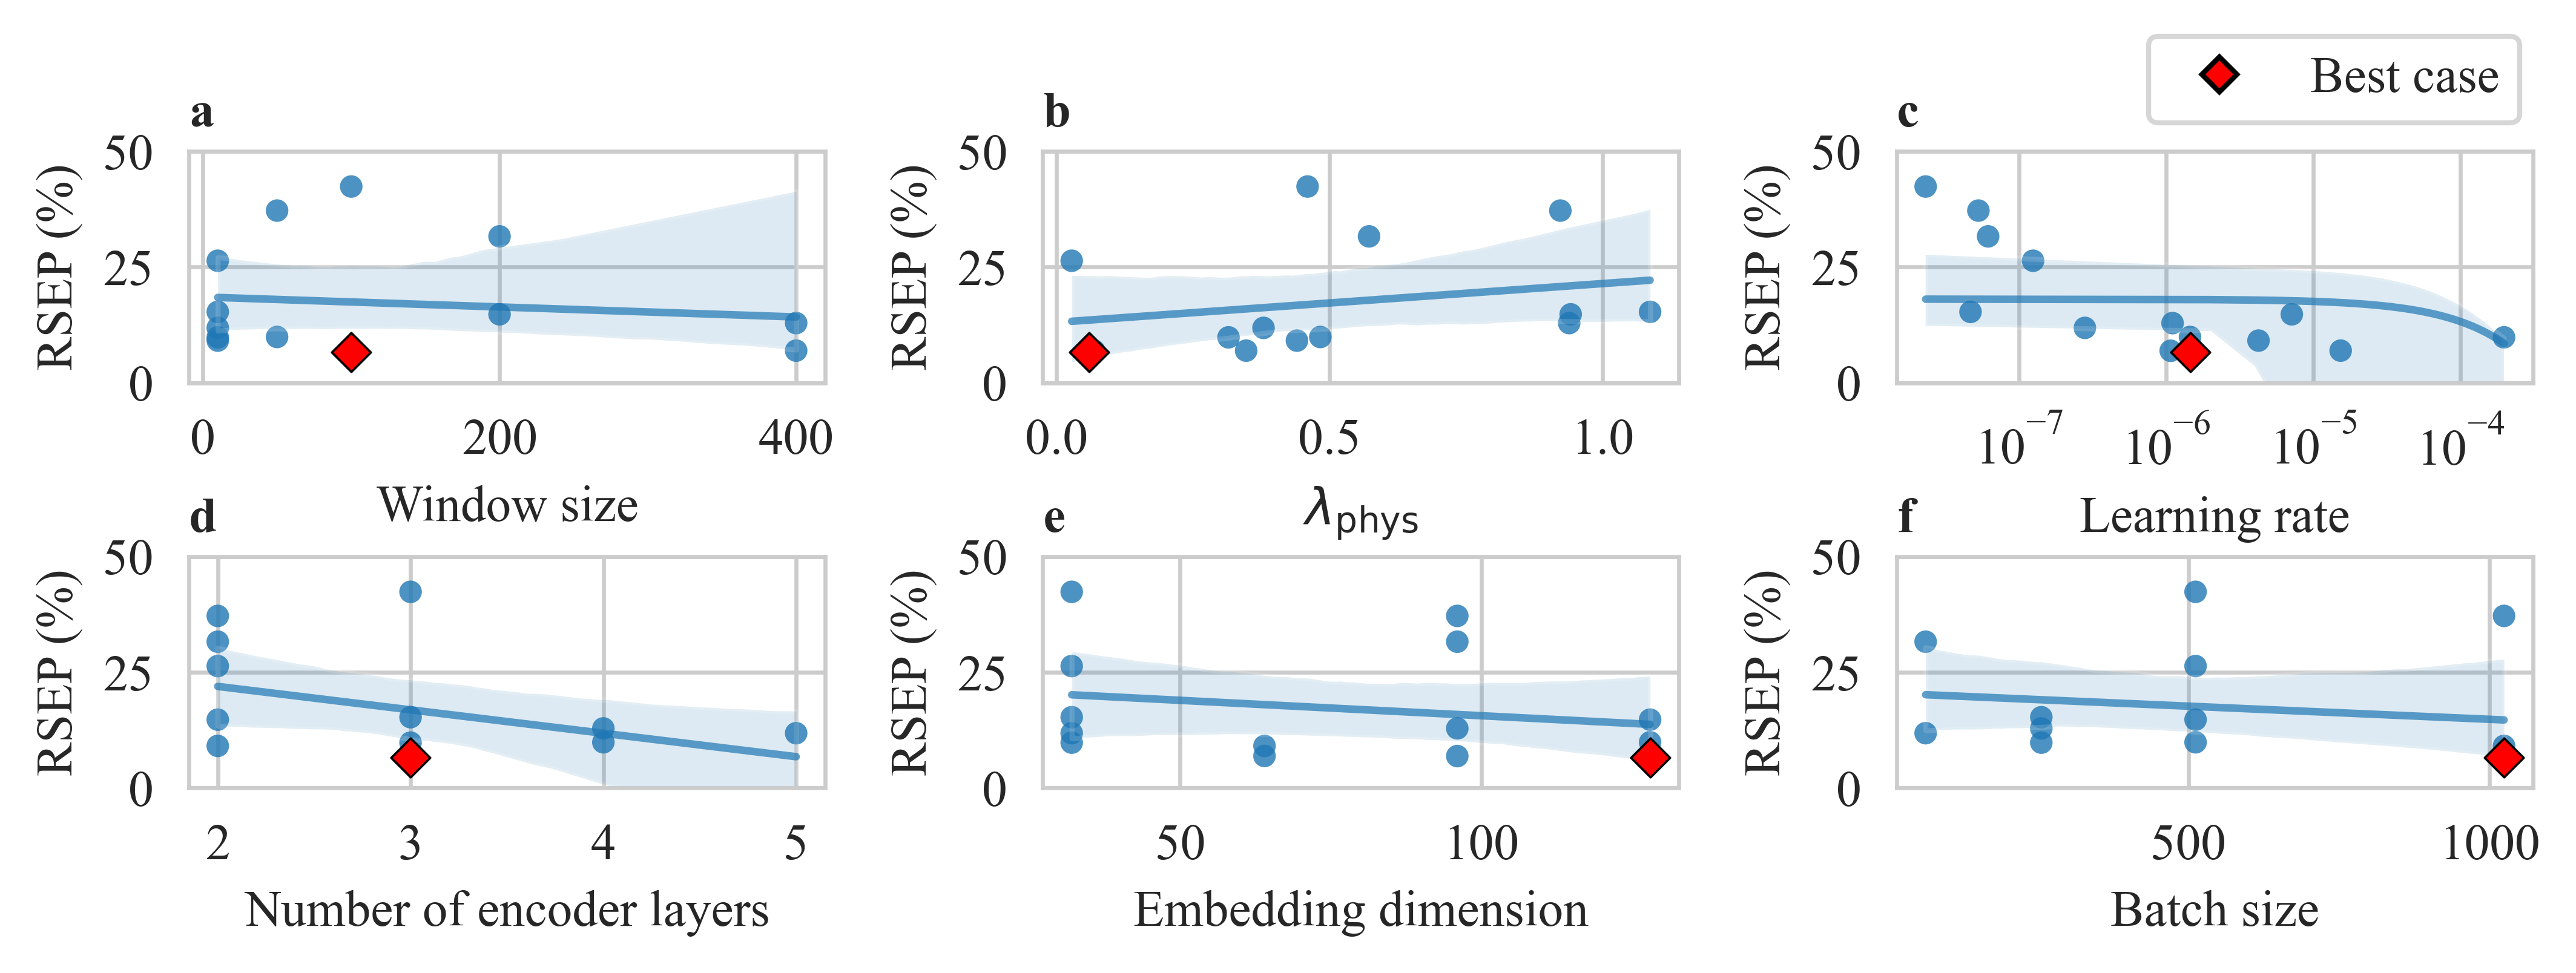

✅ Figure 1 saved to: figs/random_search_stage2_sensitivity.png


In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm   # ← NEW

# ---- Register Times New Roman from local "fonts" folder ----
font_dir = "fonts"
for fname in ["TIMES.TTF", "TIMESBD.TTF", "TIMESBI.TTF", "TIMESI.TTF"]:
    fm.fontManager.addfont(os.path.join(font_dir, fname))

# Ensure output directory exists
os.makedirs("figs", exist_ok=True)

RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Results file not found at {RESULTS_CSV}. Run Cell 10b first.")

# Load results
df = pd.read_csv(RESULTS_CSV)

# Drop rows with missing metric
metric_col = "avg_rsep_pitm"
df = df.dropna(subset=[metric_col]).copy()

# Sort once by performance
df_sorted = df.sort_values(by=metric_col, ascending=True)

print("Random search results loaded:")
print(df_sorted.head())

# -------------------------------
# 1) Figure 1: 1D sensitivity plots (journal style)
# -------------------------------
print("\nCreating Figure 1: 1D hyperparameter sensitivity plots...")

# Hyperparameters to visualize (x-axis)
param_list = [
    "window_size",
    "lambda_phys",
    "learning_rate",
    "num_layers",
    "embed_dim",
    "batch_size",
]

# Nice axis labels for each hyperparameter
param_label_map = {
    "window_size": "Window size",
    "lambda_phys": r"$\lambda_{\mathrm{phys}}$",
    "learning_rate": "Learning rate",
    "num_layers": "Number of encoder layers",
    "embed_dim": "Embedding dimension",
    "batch_size": "Batch size",
}

# Best run only
df_best = df_sorted.head(1)

sns.set_style("whitegrid")

plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 600,
    # Use the locally registered Times New Roman
    "font.family": "Times New Roman",
    "font.serif": ["Times New Roman"],
})

# Create multi-panel figure: 6 params → 2 rows × 3 cols
fig, axes = plt.subplots(2, 3, figsize=(7.2, 2.7))
axes = axes.flatten()

# Panel labels (no parentheses)
panel_labels = ["a", "b", "c", "d", "e", "f"]

# Fixed y-limits for all subplots
ymin_plot = 0.0
ymax_plot = 50.0

for i, param in enumerate(param_list):
    ax = axes[i]

    # 1) Base scatter: all runs (blue points)
    sns.scatterplot(
        data=df,
        x=param,
        y=metric_col,
        ax=ax,
        alpha=0.8,
        s=20,
        edgecolor="none",
        color="C0",
        legend=False,
    )

    # 2) Regression line WITH confidence band (blue shading)
    if param != "learning_rate":
        sns.regplot(
            data=df,
            x=param,
            y=metric_col,
            ax=ax,
            scatter=False,
            line_kws={"linewidth": 1.5, "alpha": 0.7, "color": "C0"},
        )
    else:
        sns.regplot(
            data=df,
            x=param,
            y=metric_col,
            ax=ax,
            scatter=False,
            line_kws={"linewidth": 1.5, "alpha": 0.7, "color": "C0"},
        )
        ax.set_xscale("log")

    # 3) Highlight single best run as red diamond
    sns.scatterplot(
        data=df_best,
        x=param,
        y=metric_col,
        ax=ax,
        s=30,
        marker="D",
        color="red",
        edgecolor="black",
        legend=False,
        zorder=5,
    )

    # Axis labels (no subplot titles)
    ax.set_xlabel(param_label_map.get(param, param))
    ax.set_ylabel("RSEP (%)")

    # Apply fixed y-limits and small x-margin
    ax.set_ylim(ymin_plot, ymax_plot)
    ax.margins(x=0.05)

    # Panel label a–f inside the axes
    ax.text(
        0.0, 1.25,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="left",
    )

# Hide any unused subplots (not needed here but kept for safety)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Single legend at top-right of the entire figure (only 'Best case')
best_handle = Line2D(
    [], [], marker="D", linestyle="None",
    color="red", markeredgecolor="black",
    markersize=5, label="Best case"
)

fig.legend(
    handles=[best_handle],
    loc="upper right",
    bbox_to_anchor=(0.98, 1.00),
    frameon=True,
)

plt.tight_layout()
plt.subplots_adjust(hspace=0.75)

fig1_path = os.path.join("figs", "random_search_stage2_sensitivity.png")
plt.savefig(fig1_path, dpi=600, bbox_inches="tight")
plt.show()
print(f"✅ Figure 1 saved to: {fig1_path}")


Random search results loaded:
    run_num  window_size  lambda_phys  batch_size  learning_rate  num_layers  embed_dim  avg_rsep_pitm
10       11          100     0.059975        1024       0.000001           3        128       6.579158
5         6          100     0.068778        1024       0.000001           3         96       6.898574
6         7          400     0.346999        1024       0.000015           3         64       6.927630
4         5           10     0.439994        1024       0.000004           2         64       9.095752
1         2           10     0.314693         256       0.000197           3         32       9.802991

Creating Figure 1: 1D hyperparameter sensitivity plots...


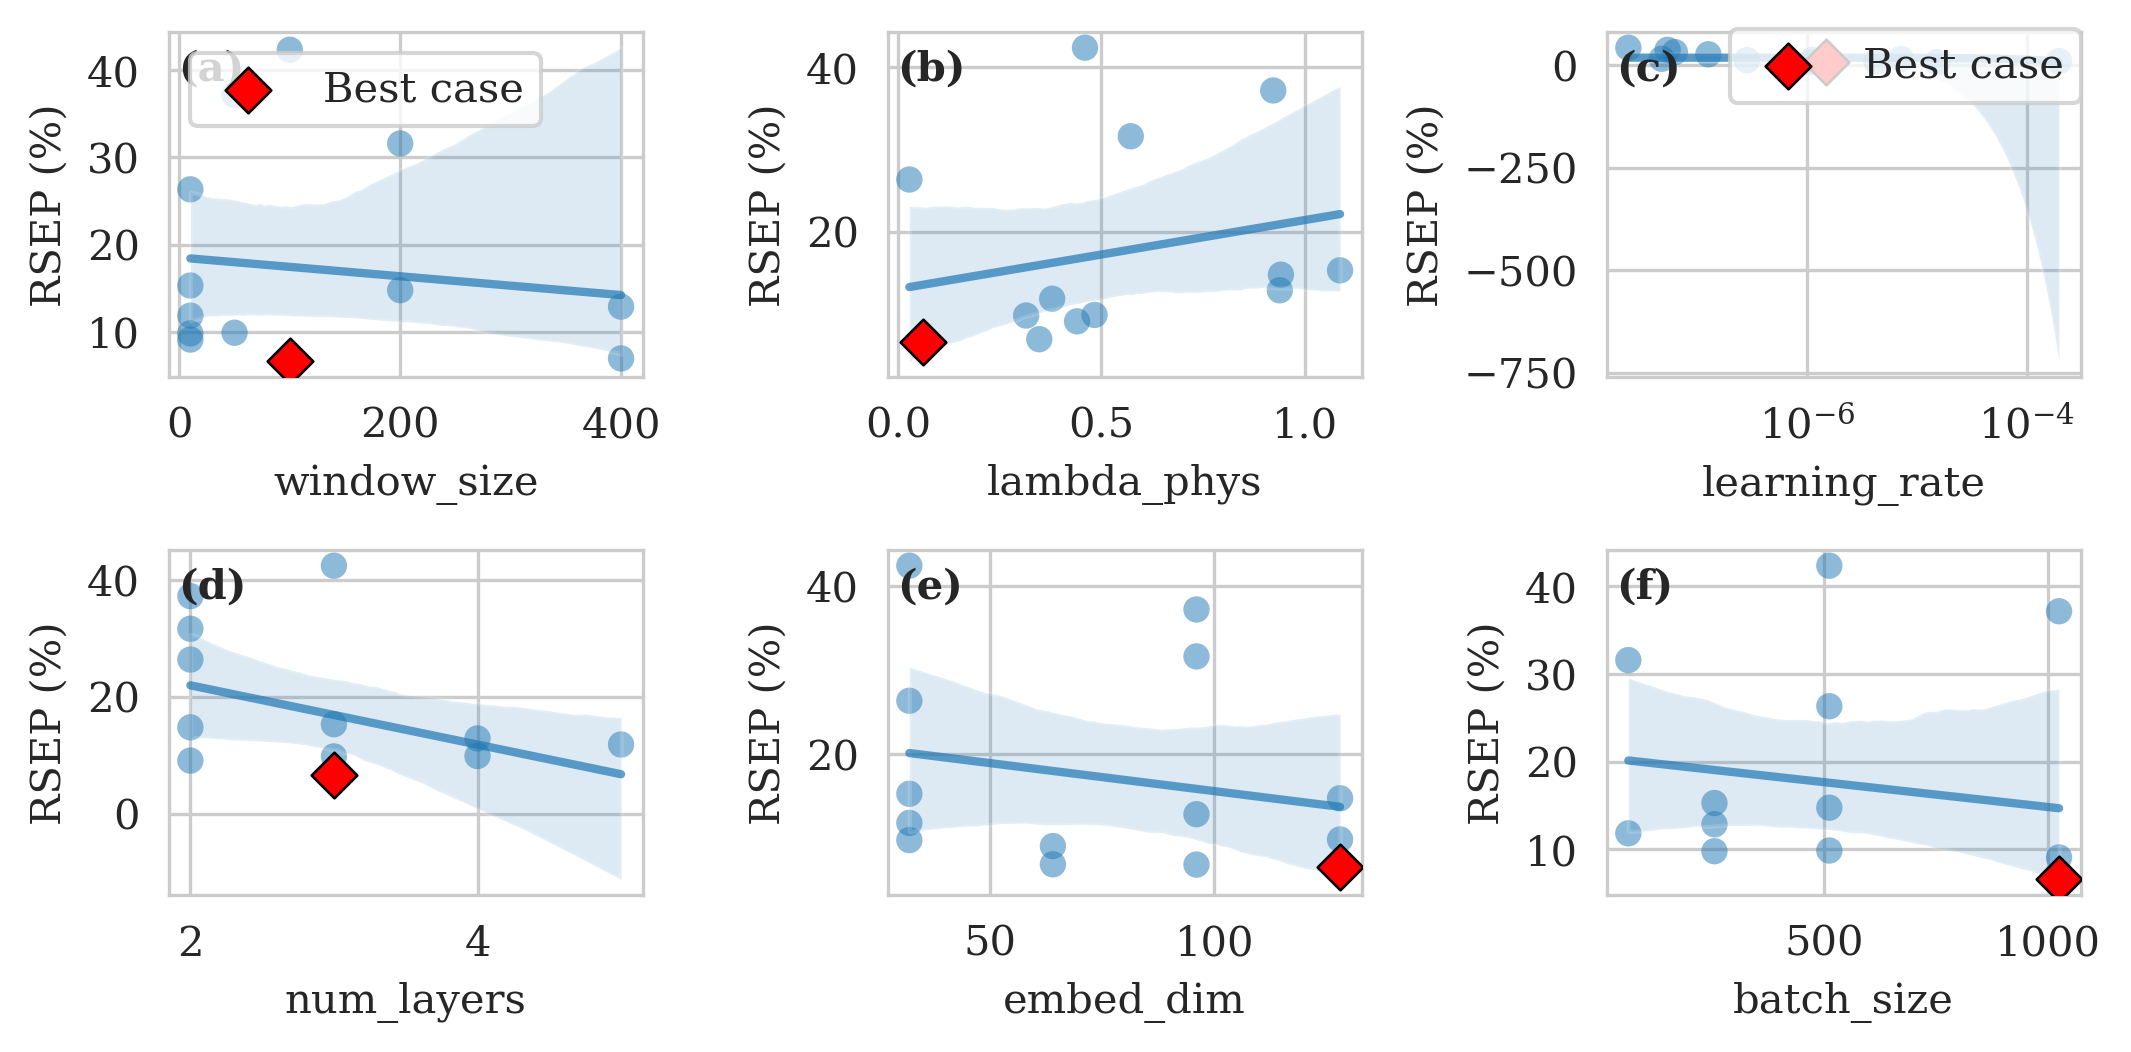

✅ Figure 1 saved to: figs/random_search_stage2_sensitivity.png

Creating Figure 2: 2D heatmaps...


/tmp/slurmtmp.41979865/ipykernel_176367/143501327.py:194: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hm.pivot_table(
/tmp/slurmtmp.41979865/ipykernel_176367/143501327.py:194: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_hm.pivot_table(


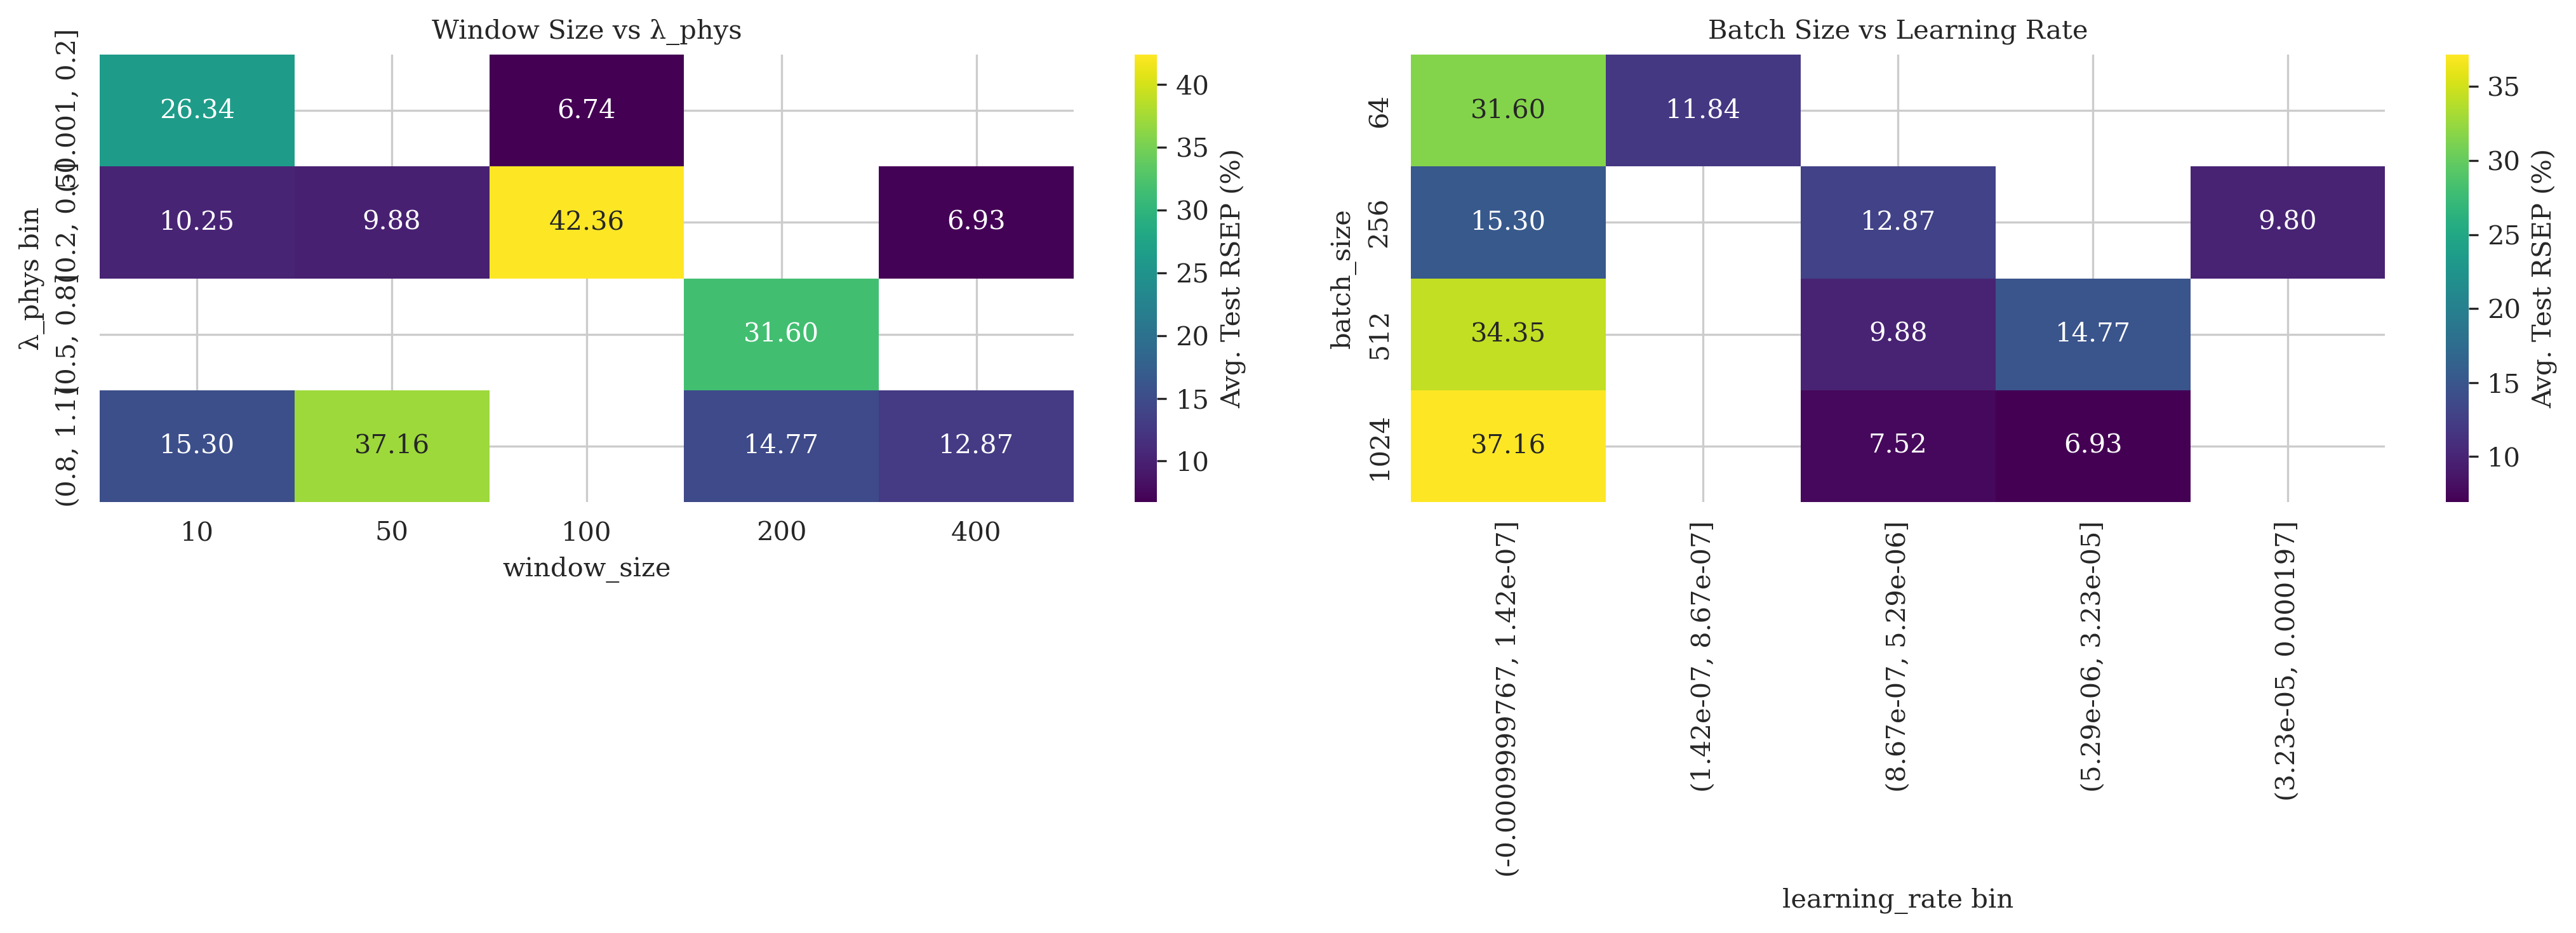

✅ Figure 2 saved to: figs/random_search_stage2_heatmaps.png

Creating Figure 3: Parallel-coordinates plot for top runs...


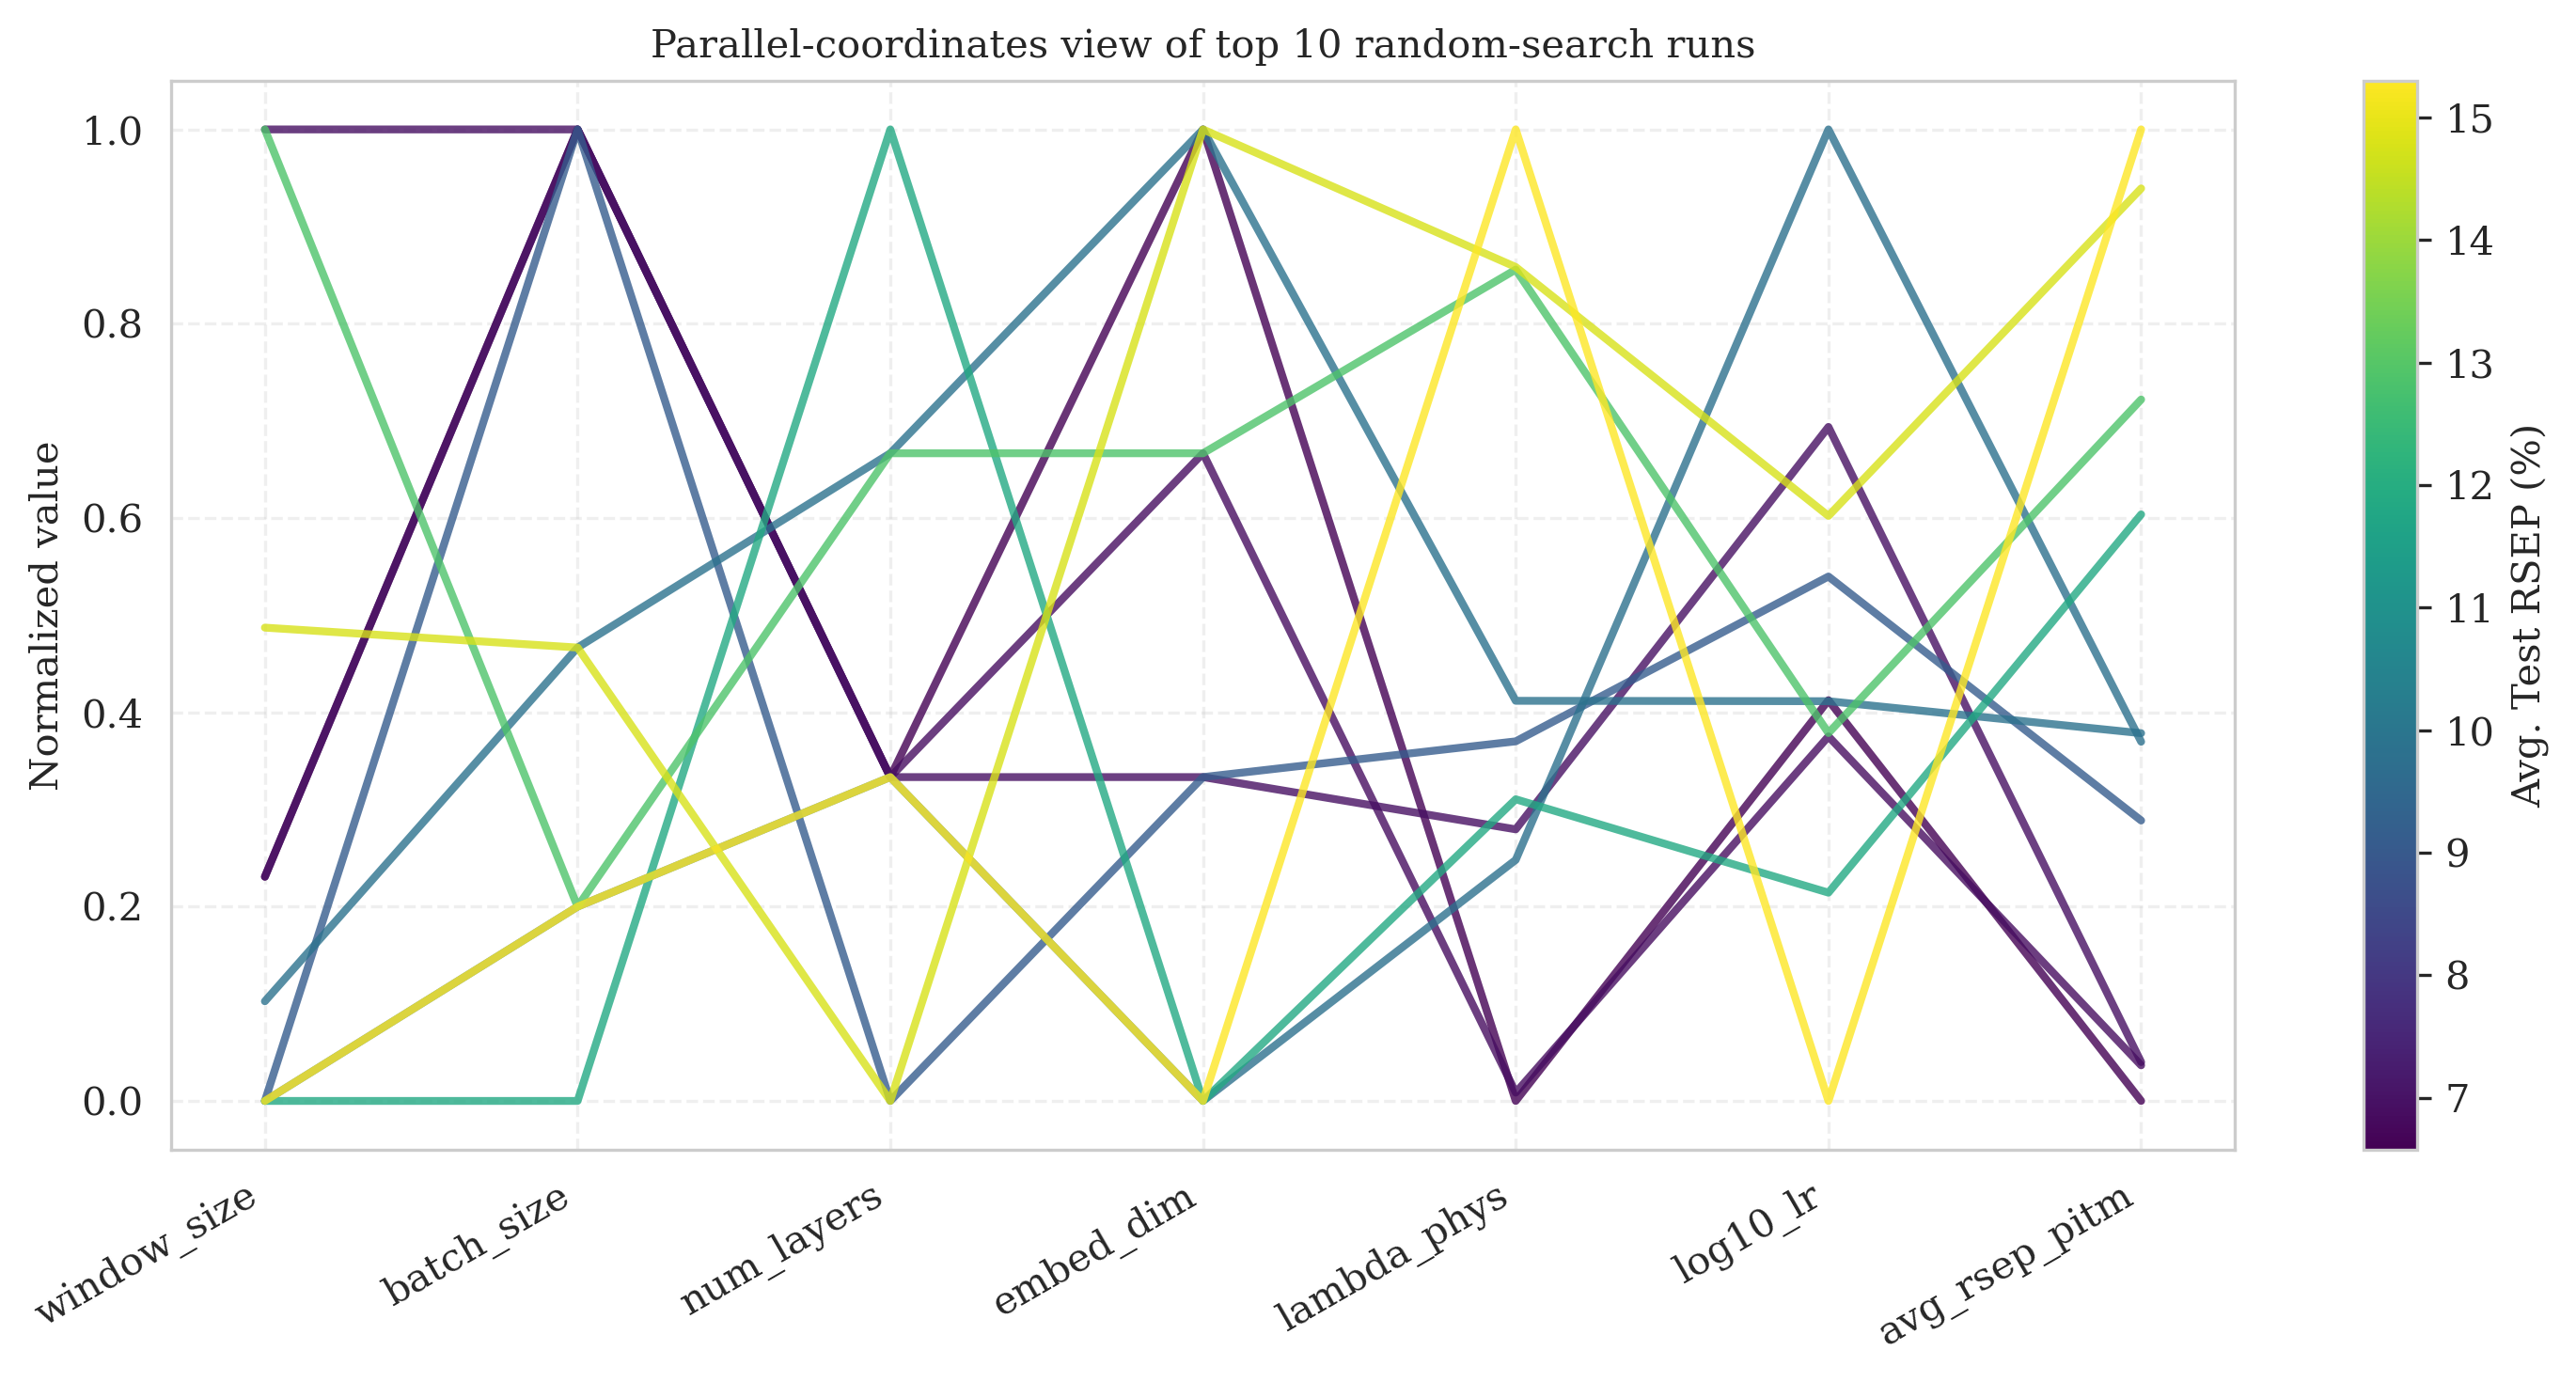

✅ Figure 3 saved to: figs/random_search_stage2_parallel_coordinates.png

Cell 10e complete: generated 3 figures + top-k table for journal use.


In [25]:
# ======================================
# Cell 10e — Publication-style Random Search Figures
# ======================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure output directory exists
os.makedirs("figs", exist_ok=True)

RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Results file not found at {RESULTS_CSV}. Run Cell 10b first.")

# Load results
df = pd.read_csv(RESULTS_CSV)

# Drop rows with missing metric
metric_col = "avg_rsep_pitm"
df = df.dropna(subset=[metric_col]).copy()

# Sort once by performance
df_sorted = df.sort_values(by=metric_col, ascending=True)

print("Random search results loaded:")
print(df_sorted.head())

# -------------------------------
# 1) Figure 1: 1D sensitivity plots (journal style)
# -------------------------------
print("\nCreating Figure 1: 1D hyperparameter sensitivity plots...")

# Hyperparameters to visualize (x-axis)
param_list = [
    "window_size",
    "lambda_phys",
    "learning_rate",
    "num_layers",
    "embed_dim",
    "batch_size",
]

# Best run only
df_best = df_sorted.head(1)

# Matplotlib / seaborn style for journal
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 300,
    # If you want serif font like IEEE:
    "font.family": "serif",
})

# Create multi-panel figure: 6 params → 2 rows × 3 cols
n_params = len(param_list)
n_cols = 3
n_rows = int(np.ceil(n_params / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.2, 3.6))
axes = axes.flatten()

# Panel labels
panel_labels = ["a", "b", "c", "d", "e", "f"]

for i, param in enumerate(param_list):
    ax = axes[i]

    # 1) Base scatter: all runs (blue points)
    sns.scatterplot(
        data=df,
        x=param,
        y=metric_col,
        ax=ax,
        alpha=0.5,
        s=40,
        edgecolor="none",
        color="C0",      # blue
    )

    # 2) Regression line (no confidence band to avoid light blue shading)
    if param != "learning_rate":
        sns.regplot(
            data=df,
            x=param,
            y=metric_col,
            ax=ax,
            scatter=False,
            # ci=None,
            line_kws={"linewidth": 2, "alpha": 0.7, "color": "C0"},
        )
    else:
        sns.regplot(
            data=df,
            x=param,
            y=metric_col,
            ax=ax,
            scatter=False,
            # ci=None,
            line_kws={"linewidth": 2, "alpha": 0.7, "color": "C0"},
        )
        ax.set_xscale("log")

    # 3) Highlight single best run as red diamond
    sns.scatterplot(
        data=df_best,
        x=param,
        y=metric_col,
        ax=ax,
        s=60,
        marker="D",
        color="red",
        edgecolor="black",
        label="Best case" if i == 0 else None,  # only first subplot gets label
        zorder=5,
    )

    # Axis labels (no subplot titles)
    ax.set_xlabel(param)
    ax.set_ylabel("RSEP (%)")

    # Panel label (a)-(f) in top-left corner
    ax.text(
        0.02, 0.95,
        panel_labels[i],
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="left",
    )

# Hide any unused subplots (in case n_params < n_rows * n_cols)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# No figure title
# fig.suptitle(...)  # removed

# Single legend at top-right of the entire figure
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        frameon=True,
    )

plt.tight_layout()
fig1_path = os.path.join("figs", "random_search_stage2_sensitivity.png")
plt.savefig(fig1_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Figure 1 saved to: {fig1_path}")


# -------------------------------
# 2) Figure 2: 2D heatmaps
#    (window_size × lambda_phys, batch_size × learning_rate)
# -------------------------------
print("\nCreating Figure 2: 2D heatmaps...")

# Helper: create a pivot table for a heatmap
def make_heatmap_pivot(df_in, x_col, y_col, value_col, x_bins=None, y_bins=None,
                       aggfunc="mean"):
    df_hm = df_in.copy()

    # Bin x if bins provided and it's continuous
    if x_bins is not None:
        df_hm[f"{x_col}_bin"] = pd.cut(df_hm[x_col], bins=x_bins, include_lowest=True)
        x_label = f"{x_col}_bin"
    else:
        x_label = x_col

    # Bin y if bins provided
    if y_bins is not None:
        df_hm[f"{y_col}_bin"] = pd.cut(df_hm[y_col], bins=y_bins, include_lowest=True)
        y_label = f"{y_col}_bin"
    else:
        y_label = y_col

    pivot = df_hm.pivot_table(
        index=y_label,
        columns=x_label,
        values=value_col,
        aggfunc=aggfunc
    )

    # Order axes
    pivot = pivot.sort_index(axis=0)
    pivot = pivot.sort_index(axis=1)

    return pivot

# Heatmap 1: window_size vs lambda_phys
lambda_bins = [0.0, 0.2, 0.5, 0.8, 1.1]  # tune if needed
pivot1 = make_heatmap_pivot(
    df,
    x_col="window_size",
    y_col="lambda_phys",
    value_col=metric_col,
    x_bins=None,          # window_size is discrete
    y_bins=lambda_bins
)

# Heatmap 2: batch_size vs learning_rate (log-binned)
lr_bins = np.logspace(np.log10(df["learning_rate"].min()),
                      np.log10(df["learning_rate"].max()),
                      6)
pivot2 = make_heatmap_pivot(
    df,
    x_col="learning_rate",
    y_col="batch_size",
    value_col=metric_col,
    x_bins=lr_bins,
    y_bins=None          # batch_size is discrete
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1
sns.heatmap(
    pivot1,
    ax=axes[0],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Avg. Test RSEP (%)"}
)
axes[0].set_title("Window Size vs λ_phys")
axes[0].set_xlabel("window_size")
axes[0].set_ylabel("λ_phys bin")

# Heatmap 2
sns.heatmap(
    pivot2,
    ax=axes[1],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Avg. Test RSEP (%)"}
)
axes[1].set_title("Batch Size vs Learning Rate")
axes[1].set_xlabel("learning_rate bin")
axes[1].set_ylabel("batch_size")

plt.tight_layout()
fig2_path = os.path.join("figs", "random_search_stage2_heatmaps.png")
plt.savefig(fig2_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Figure 2 saved to: {fig2_path}")

# -------------------------------
# 3) Figure 3: Parallel-coordinates style plot for top runs
# -------------------------------
print("\nCreating Figure 3: Parallel-coordinates plot for top runs...")

# Choose how many best runs to show
pc_top_n = min(10, len(df_sorted))
df_pc = df_sorted.head(pc_top_n).copy()

# For visualization, use log10(learning_rate)
df_pc["log10_lr"] = np.log10(df_pc["learning_rate"])

# Columns to include in the parallel plot (ordered)
pc_cols = [
    "window_size",
    "batch_size",
    "num_layers",
    "embed_dim",
    "lambda_phys",
    "log10_lr",
    metric_col,
]

# Normalize each column to [0, 1] for plotting
df_pc_norm = df_pc[pc_cols].copy()
col_min = df_pc_norm.min()
col_max = df_pc_norm.max()
df_pc_norm = (df_pc_norm - col_min) / (col_max - col_min + 1e-12)

# Color lines by performance (original metric)
values = df_pc[metric_col].values
vmin, vmax = values.min(), values.max()
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(figsize=(10, 5))

for idx in range(len(df_pc_norm)):
    y = df_pc_norm.iloc[idx].values
    x = np.arange(len(pc_cols))

    color = cmap(norm(values[idx]))
    ax.plot(x, y, color=color, linewidth=2, alpha=0.8)

# Axis formatting
ax.set_xticks(np.arange(len(pc_cols)))
ax.set_xticklabels(pc_cols, rotation=30, ha="right")
ax.set_ylabel("Normalized value")

# Colorbar for performance
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Avg. Test RSEP (%)")

ax.set_title(f"Parallel-coordinates view of top {pc_top_n} random-search runs")
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
fig3_path = os.path.join("figs", "random_search_stage2_parallel_coordinates.png")
plt.savefig(fig3_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Figure 3 saved to: {fig3_path}")

# -------------------------------
# 4) Save top-k configurations as a table
# -------------------------------
# print("\nSaving top-k configurations for publication...")

# top_k = 5
# topk_table = df_sorted.head(top_k).copy()
# topk_path_csv = os.path.join("ablation", "random_search_stage2_top5.csv")
# topk_table.to_csv(topk_path_csv, index=False)

# # (Optional) also dump a LaTeX table snippet
# topk_path_tex = os.path.join("ablation", "random_search_stage2_top5_table.tex")
# with open(topk_path_tex, "w") as f:
#     f.write(topk_table.to_latex(index=False, float_format="%.3g"))

# print(f"✅ Top-{top_k} table saved as CSV → {topk_path_csv}")
# print(f"✅ Top-{top_k} table saved as LaTeX → {topk_path_tex}")

print("\nCell 10e complete: generated 3 figures + top-k table for journal use.")


In [12]:
# ==========================================================
# Cell 11 — Load Best Model from Random Search & Evaluate
# ==========================================================
import os
import tensorflow as tf
import numpy as np
import pandas as pd

RESULTS_CSV = os.path.join("ablation", "random_search_stage2_results.csv")
if not os.path.exists(RESULTS_CSV):
    raise FileNotFoundError(f"Random search results not found at: {RESULTS_CSV}")

df_results = pd.read_csv(RESULTS_CSV)

# Sort by avg_rsep_pitm ascending (lower is better)
df_sorted = df_results.sort_values(by="avg_rsep_pitm", ascending=True)
best_row = df_sorted.iloc[0]

print("🏆  Best model found from Random Search (Stage 2)")
print(best_row)

BEST_RUN_NUM   = int(best_row["run_num"])
BEST_WS        = int(best_row["window_size"])
BEST_LAYERS    = int(best_row["num_layers"])
BEST_EMBED     = int(best_row["embed_dim"])
BEST_LAMBDA_PHYS = float(best_row["lambda_phys"])

# Rebuild the model architecture with these hyperparameters
print(f"\nRebuilding best model from random search:")
print(f"  Run number:   {BEST_RUN_NUM}")
print(f"  Window Size:  {BEST_WS}")
print(f"  Num Layers:   {BEST_LAYERS}")
print(f"  Embed Dim:    {BEST_EMBED}")
print(f"  lambda_phys:  {BEST_LAMBDA_PHYS:.4f}")

tf.keras.backend.clear_session()

model = build_pitm_model(
    window_size=BEST_WS,
    num_groups=NUM_GROUPS,
    embed_dim=BEST_EMBED,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=BEST_LAYERS,
    dropout=DROPOUT
)

# Load the best checkpoint from that run
run_name = f"rs2_run{BEST_RUN_NUM}"
CHECKPOINT_NAME = f"{run_name}_best.h5"
MODEL_TO_TEST = os.path.join("checkpoints", CHECKPOINT_NAME)

if not os.path.exists(MODEL_TO_TEST):
    raise FileNotFoundError(f"Checkpoint not found: {MODEL_TO_TEST}")
else:
    model.load_weights(MODEL_TO_TEST)
    print(f"\n✅ Successfully loaded weights from: {MODEL_TO_TEST}")

# Run full evaluation on TEST cells with plots
print("\nRunning final evaluation on all TEST cells...")
results = evaluate_model_on_test(
    model,
    window_size=BEST_WS,
    stride=STRIDE,
    plot_suffix="BEST_RANDOM_SEARCH_MODEL",
    do_plot=True
)

rsep_values = [res[3] for res in results if np.isfinite(res[3])]
final_avg_rsep = np.mean(rsep_values) if rsep_values else np.nan

print("\n" + "="*50)
print(f"Per-Cell Evaluation Complete.")
print(f"Average RSEP: {final_avg_rsep:.4f}%")
print("="*50)


🏆  Best model found from Random Search (Stage 2)
run_num            3.000000
window_size       10.000000
lambda_phys        0.110198
batch_size       256.000000
learning_rate      0.000029
num_layers         1.000000
embed_dim         32.000000
avg_rsep_pitm      6.043621
Name: 2, dtype: float64

Rebuilding best model from random search:
  Run number:   3
  Window Size:  10
  Num Layers:   1
  Embed Dim:    32
  lambda_phys:  0.1102

✅ Successfully loaded weights from: checkpoints/rs2_run3_best.h5

Running final evaluation on all TEST cells...


Evaluating test cells:   0%|                                        | 0/1 [00:00<?, ?it/s]

  (Testing PBROM_data_NASA_B5.mat: using 'NASA_Cells_1' scaler, ID: 0)


Evaluating test cells:   0%|                                        | 0/1 [00:02<?, ?it/s]


InternalError: Graph execution error:

RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:376) stream->parent()->GetBlasGemmAlgorithms(stream, &algorithms) 
	 [[{{node cluster_0_1/xla_compile}}]] [Op:__inference_predict_function_1707]

In [ ]:
# ==========================================================
# Cell 12 — Export Best-Model Test Curves for This Battery Group
# ==========================================================
import os
import joblib
import numpy as np

# 🔧 1) Set a short label for THIS notebook's battery group
#     ➜ Change ONLY this string in your other scripts
BATTERY_GROUP_LABEL = "PBROM_Cells_2"   # <-- EDIT for each group script

# 🔧 2) Directory where we will save the export file
EXPORT_DIR = "export_curves"
os.makedirs(EXPORT_DIR, exist_ok=True)

# ----------------------------------------------------------
# Helper: collect the exact curves used in Cell 11's plots
# ----------------------------------------------------------
def collect_test_curves_for_export(model, window_size, stride):
    """
    For each TEST cell:
      - Run predict_cell(...)
      - Align model outputs to experimental timestamps
      - Build a dictionary with everything needed to re-plot:
            * t_exp_hours, Q_exp_pct   (scatter)
            * t_dense_hours, Q_pb_pct, Q_hat_pct  (lines)
    Returns:
      list of dicts, one per test cell
    """
    curves = []

    for fn in TEST_FILES:
        # This uses the same predict_cell that Cell 6a / 11 rely on
        out = predict_cell(model, fn, window_size, stride)
        if out is None or len(out) < 7:
            print(f"[Export] WARNING: predict_cell returned invalid output for {fn}")
            continue

        (t_dense, q_exp_norm_d, q_pb_norm_d,
         q_hat_norm_d, cap_nom, Time_s_full, t_exp) = out

        if t_dense.size == 0:
            print(f"[Export] WARNING: no windows for {fn}, skipping.")
            continue

        # --- Reproduce the same alignment as in evaluate_model_on_test ---
        ts_dense = t_dense
        # Restrict experimental timestamps to the model coverage
        t_exp_use = t_exp[(t_exp >= ts_dense[0]) & (t_exp <= ts_dense[-1])]
        if t_exp_use.size == 0:
            print(f"[Export] WARNING: no experimental times within model horizon for {fn}, skipping.")
            continue

        idx = nearest_indices(ts_dense, t_exp_use)
        if idx.size == 0:
            print(f"[Export] WARNING: nearest_indices returned empty for {fn}, skipping.")
            continue

        # Stamp experimental/Q curves at those timestamps
        Q_exp_norm_stamp   = q_exp_norm_d[idx]
        Q_pb_norm_stamp    = q_pb_norm_d[idx]
        Q_pred_norm_stamp  = q_hat_norm_d[idx]

        # Convert to plotting units (same as Cell 6a / 11):
        #   time in hours, degradation in %
        t_exp_hours   = t_exp_use / 3600.0
        t_dense_hours = t_dense / 3600.0

        Q_exp_pct = 100.0 * Q_exp_norm_stamp
        Q_pb_pct  = 100.0 * q_pb_norm_d
        Q_hat_pct = 100.0 * q_hat_norm_d

        curves.append({
            "file_name":   os.path.basename(fn),
            "t_exp_hours": t_exp_hours.astype(np.float64),
            "Q_exp_pct":   Q_exp_pct.astype(np.float64),
            "t_dense_hours": t_dense_hours.astype(np.float64),
            "Q_pb_pct":    Q_pb_pct.astype(np.float64),
            "Q_hat_pct":   Q_hat_pct.astype(np.float64),
            "Cap_Nom":     float(cap_nom),
        })

    return curves

# ----------------------------------------------------------
# 3) Collect curves + package everything into one object
# ----------------------------------------------------------
print("\n[Export] Collecting curves for best random-search model...")

# We assume Cell 11 has already defined:
#   - model           (best model loaded)
#   - BEST_WS         (best window size)
#   - STRIDE          (global stride)
#   - results         (per-cell metrics from evaluate_model_on_test)
curves = collect_test_curves_for_export(
    model,
    window_size=BEST_WS,
    stride=STRIDE
)

if not curves:
    print("[Export] No curves collected — nothing to save.")
else:
    export_payload = {
        "battery_group": BATTERY_GROUP_LABEL,
        "window_size":   BEST_WS,
        "stride":        STRIDE,
        "results_table": results,   # metrics from Cell 11 (MSE / RSEP / MAPE)
        "curves":        curves,    # list of dicts (per test cell)
    }

    # File name includes the group label so different scripts won't collide
    export_path = os.path.join(
        EXPORT_DIR,
        f"pitm_best_randomsearch_curves_{BATTERY_GROUP_LABEL}.joblib"
    )
    joblib.dump(export_payload, export_path)

    print(f"[Export] Saved best-model curves for group '{BATTERY_GROUP_LABEL}'")
    print(f"         → {export_path}")
    print(f"         Cells exported: {len(curves)}")
